# Customer Segmentation of Lisbon Hotels Dataset

### Importing libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, count, when
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

spark = SparkSession.builder.appName("HotelCustomerAnalysis").getOrCreate()

%matplotlib inline

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/24 10:21:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Initializing spark session and importing dataset

In [3]:
df = spark.read.csv('./HotelCustomersDataset.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- DaysSinceCreation: integer (nullable = true)
 |-- NameHash: string (nullable = true)
 |-- DocIDHash: string (nullable = true)
 |-- AverageLeadTime: integer (nullable = true)
 |-- LodgingRevenue: double (nullable = true)
 |-- OtherRevenue: double (nullable = true)
 |-- BookingsCanceled: integer (nullable = true)
 |-- BookingsNoShowed: integer (nullable = true)
 |-- BookingsCheckedIn: integer (nullable = true)
 |-- PersonsNights: integer (nullable = true)
 |-- RoomNights: integer (nullable = true)
 |-- DaysSinceLastStay: integer (nullable = true)
 |-- DaysSinceFirstStay: integer (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- SRHighFloor: integer (nullable = true)
 |-- SRLowFloor: integer (nullable = true)
 |-- SRAccessibleRoom: integer (nullable = true)
 |-- SRMediumFloor: integer (nullable = tru

In [4]:
df.show(5)

24/04/24 10:21:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-----------+----+-----------------+--------------------+--------------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+--------------------+--------------------+-----------+----------+----------------+-------------+---------+--------+------+-------------+---------+--------------+------------------+--------------------+-----------+
| ID|Nationality| Age|DaysSinceCreation|            NameHash|           DocIDHash|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay| DistributionChannel|       MarketSegment|SRHighFloor|SRLowFloor|SRAccessibleRoom|SRMediumFloor|SRBathtub|SRShower|SRCrib|SRKingSizeBed|SRTwinBed|SRNearElevator|SRAwayFromElevator|SRNoAlcoholInMiniBar|SRQuietRoom|
+---+-----------+----+-----------------+--------------------+--------------------+----------

## Exploratory Data Analysis
- Preprocess the data such as imputing missing values, removing unnecessary columns, understand the statistics of each column

- Visualize the distribution of numerical variables such as Age, AverageLeadTime, LodgingRevenue, and OtherRevenue using histograms or kernel density plots.

- Explore the distribution of categorical variables like Nationality, DistributionChannel, MarketSegment using bar plots to understand the frequency of different categories.

### Data preprocessing

#### Cast 'Age' as Integer

In [5]:
df = df.withColumn("Age", df["Age"].cast("integer"))

#### Drop unwanted columns

In [6]:
df = df.drop(*["NameHash", "DocIDHash"])

#### Rename columns as desired

In [7]:
df = df.withColumnRenamed("SRHighFloor", "HighFloor") \
            .withColumnRenamed("SRLowFloor", "LowFloor") \
            .withColumnRenamed("SRMediumFloor", "MediumFloor") \
            .withColumnRenamed("SRAccessibleRoom", "AccessibleRoom") \
            .withColumnRenamed("SRQuietRoom", "QuietRoom") \
            .withColumnRenamed("SRBathtub", "Bathtub") \
            .withColumnRenamed("SRShower", "Shower") \
            .withColumnRenamed("SRCrib", "Crib") \
            .withColumnRenamed("SRKingSizeBed", "KingBed") \
            .withColumnRenamed("SRTwinBed", "TwinBed") \
            .withColumnRenamed("SRNearElevator", "ElevatorNear") \
            .withColumnRenamed("SRAwayFromElevator", "ElevatorAway") \
            .withColumnRenamed("SRNoAlcoholInMiniBar", "NoAlcohol")

### Describe statistics of the dataframe

In [8]:
df.describe().show()

24/04/24 10:21:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+------------------+-----------+------------------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|summary|                ID|Nationality|               Age| DaysSinceCreation|  AverageLeadTime|   LodgingRevenue|      OtherRevenue|    BookingsCanceled|    BookingsNoShowed| BookingsCheckedIn|    PersonsNights|        RoomNights|DaysSinceLastStay|DaysSinceFirstStay| DistributionChannel|       MarketSegment|          HighFloor|            LowFloor|      AccessibleRoom|         MediumFloor|             Bathtub|      

### Check for missing values

In [9]:
from pyspark.sql.functions import count, when, col

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()

+---+-----------+----+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+-------------------+-------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+
| ID|Nationality| Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay|DistributionChannel|MarketSegment|HighFloor|LowFloor|AccessibleRoom|MediumFloor|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|QuietRoom|
+---+-----------+----+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+-------------------+-------------+---------+--------+--------------+-----------+

#### Impute missing value in 'Age' with its mean

In [10]:
from pyspark.sql.functions import mean

mean_age = df.select(mean('Age')).collect()[0][0] # get mean of 'age'

df = df.fillna(mean_age, subset=['Age']) # impute 'age' with mean_age

### Unique values in each column

In [11]:
from pyspark.sql.functions import col

unique_counts = df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns))
unique_counts.show()

+-----+-----------+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+-------------------+-------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+
|   ID|Nationality|Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay|DistributionChannel|MarketSegment|HighFloor|LowFloor|AccessibleRoom|MediumFloor|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|QuietRoom|
+-----+-----------+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+-------------------+-------------+---------+--------+--------------+---------

## Numerical variables

### Age and AverageLeadTime

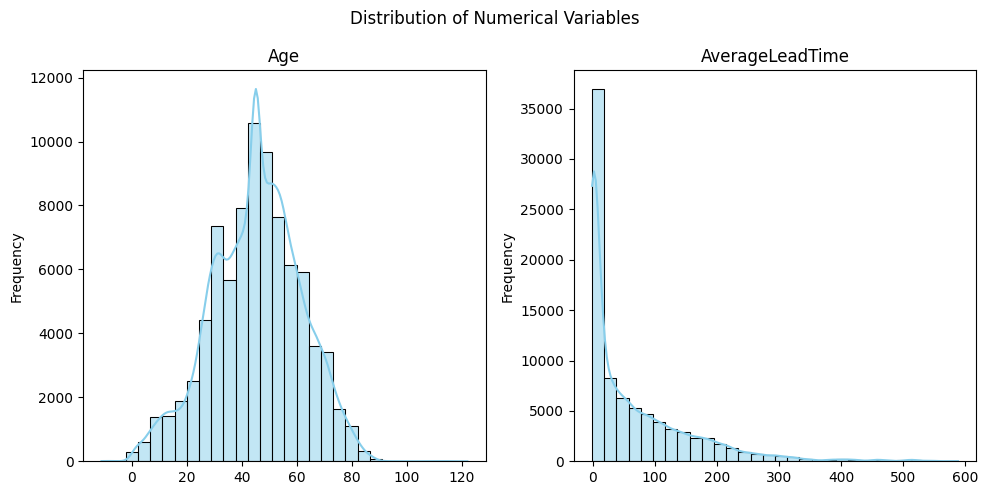

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten() # flatten the axes array to make it easier to iterate over

for i, col in enumerate(['Age','AverageLeadTime']):
    sns.histplot(df.select(col).toPandas()[col], bins=30, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Numerical Variables')
plt.tight_layout()
plt.show()

- Age seems to be normally distributed with average between 40 to 50
- AverageLeadTime which is the average number of days elapsed between the customer’s booking date and arrival date, shows that a large number of bookings are usually made 20 days in advance. This gradaully increases to bookings made upto a year in advance.

### Revenue (Lodging, Other)

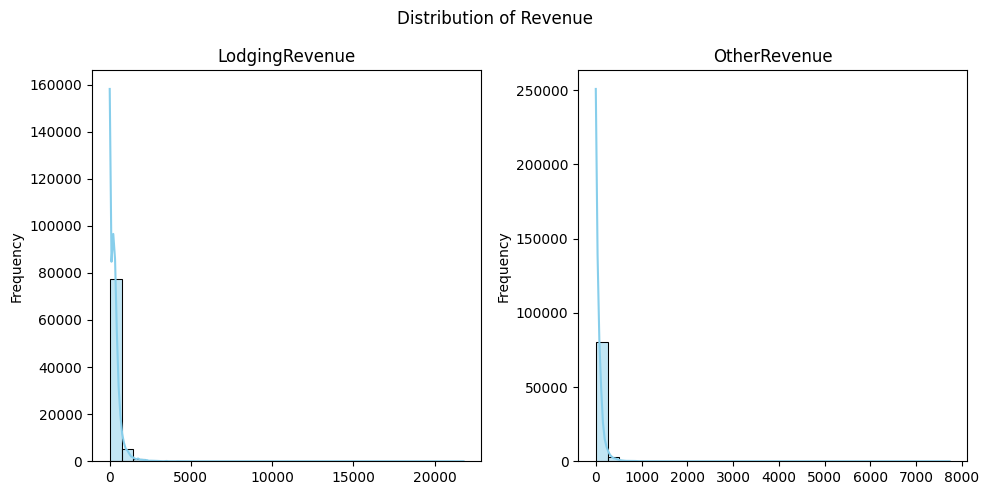

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

for i, col in enumerate(['LodgingRevenue', 'OtherRevenue']):
    sns.histplot(df.select(col).toPandas()[col], bins=30, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Revenue')
plt.tight_layout()
plt.show()

- LodgingRevenue is the total amount spent on lodging expenses which includes room, crib, and other related lodging expenses.
- OtherRevenue is the total amount spent on other expenses which includes food, beverage, spa, and other expenses.

### Bookings (Cancelled, No show, Check ins)

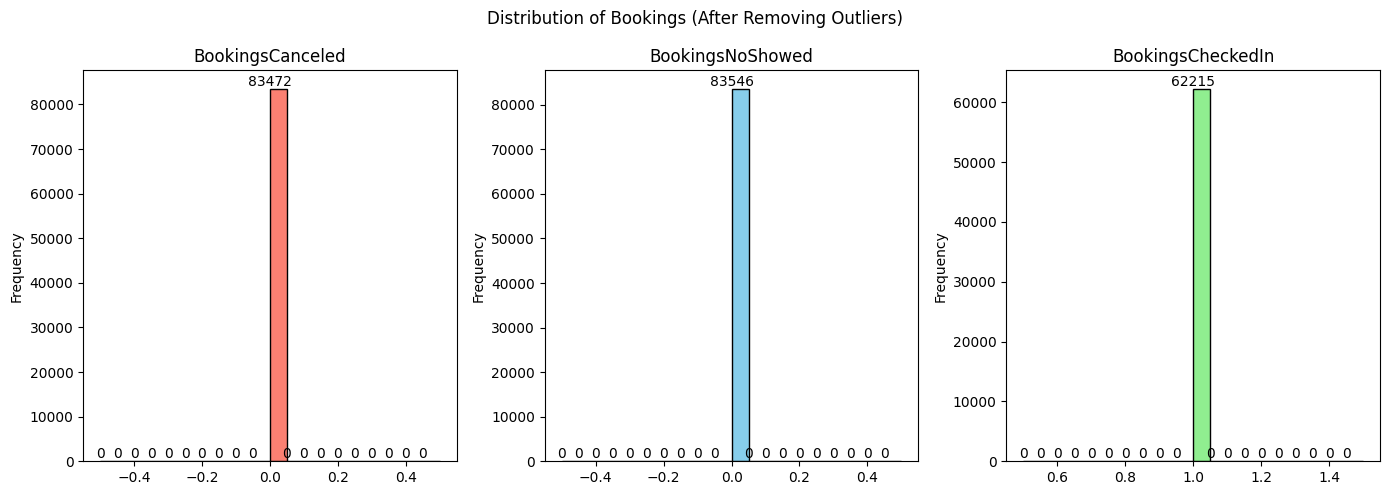

In [28]:
import numpy as np
import matplotlib.pyplot as plt

booking_data = df.select('BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn').toPandas()

# Function to remove outliers (IQR method)
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

booking_data_no_outliers = booking_data.apply(remove_outliers_iqr)

colors = ['salmon', 'skyblue', 'lightgreen'] # assign colors to each variable

plt.figure(figsize=(14, 5)) # plot histogram

for i, col in enumerate(booking_data_no_outliers.columns):
    plt.subplot(1, 3, i+1)
    counts, bins, _ = plt.hist(booking_data_no_outliers[col], bins=20, color=colors[i], edgecolor='black')
    plt.title(f'{col}')
    plt.xlabel('')
    plt.ylabel('Frequency')

    for count, bin in zip(counts, bins):
        plt.text(bin, count, str(int(count)), ha='center', va='bottom') # add text to each bar

plt.suptitle('Distribution of Bookings (After Removing Outliers)')
plt.tight_layout()
plt.show()


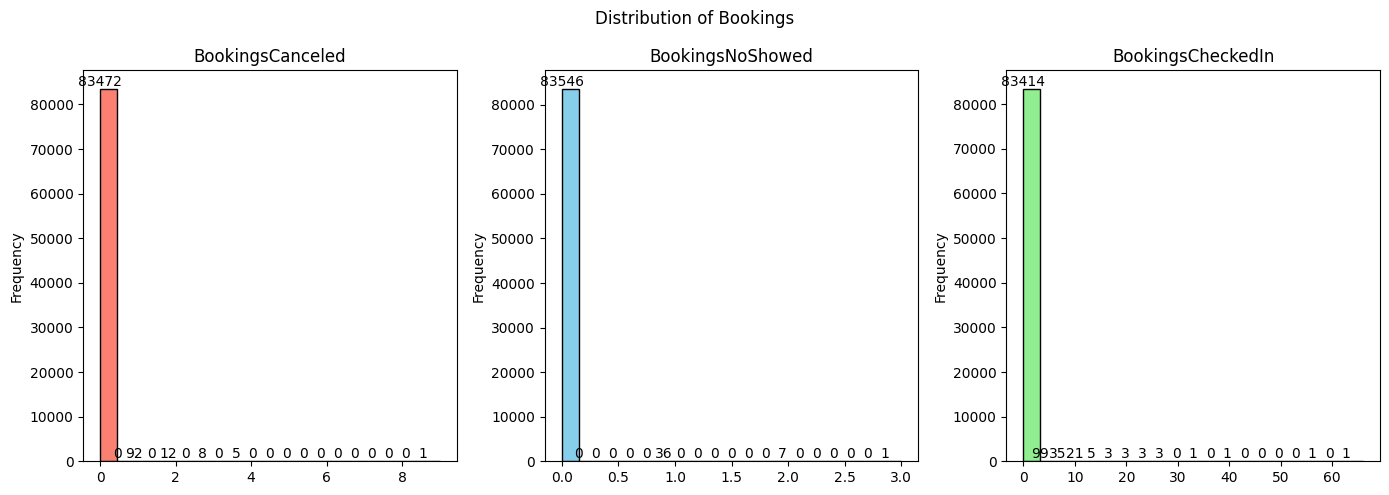

In [29]:
booking_data = df.select('BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn').toPandas()

colors = ['salmon', 'skyblue', 'lightgreen']

plt.figure(figsize=(14, 5)) # plot histogram

for i, col in enumerate(booking_data.columns):
    plt.subplot(1, 3, i+1)
    counts, bins, _ = plt.hist(booking_data[col], bins=20, color=colors[i], edgecolor='black')
    plt.title(f'{col}')
    plt.xlabel('')
    plt.ylabel('Frequency')

    for count, bin in zip(counts, bins):
        plt.text(bin, count, str(int(count)), ha='center', va='bottom') # add text to each bar

plt.suptitle('Distribution of Bookings')
plt.tight_layout()
plt.show()

### Nights (Persons, Rooms)

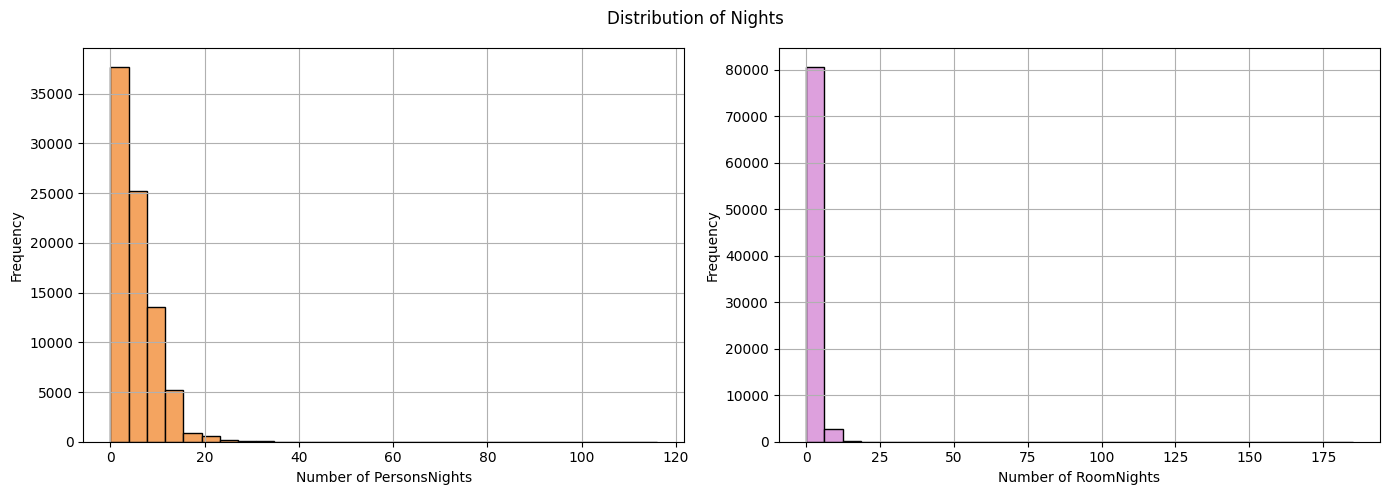

In [30]:
persons_nights = df.select('PersonsNights').toPandas()
room_nights = df.select('RoomNights').toPandas()

plt.figure(figsize=(14, 5)) # create subplot

# PersonsNights (histogram)
plt.subplot(1, 2, 1)
plt.hist(persons_nights['PersonsNights'], bins=30, color='sandybrown', edgecolor='black')
plt.xlabel('Number of PersonsNights')
plt.ylabel('Frequency')
plt.grid(True)

# RoomNights (histogram)
plt.subplot(1, 2, 2)
plt.hist(room_nights['RoomNights'], bins=30, color='plum', edgecolor='black')
plt.xlabel('Number of RoomNights')
plt.ylabel('Frequency')
plt.grid(True)

plt.suptitle('Distribution of Nights')
plt.tight_layout()
plt.show()

- PersonsNights is the total number of persons/nights that the costumer stayed at the hotel. Person/nights in turn is calculated by multiplying the number of nights by number of people accompanied by the customer.
- RoomNights is the total of room/nights the customer stayed at the hotel. Room/nights in turn is calculated by multiplying the number of
rooms of each booking by the number of nights of the booking.

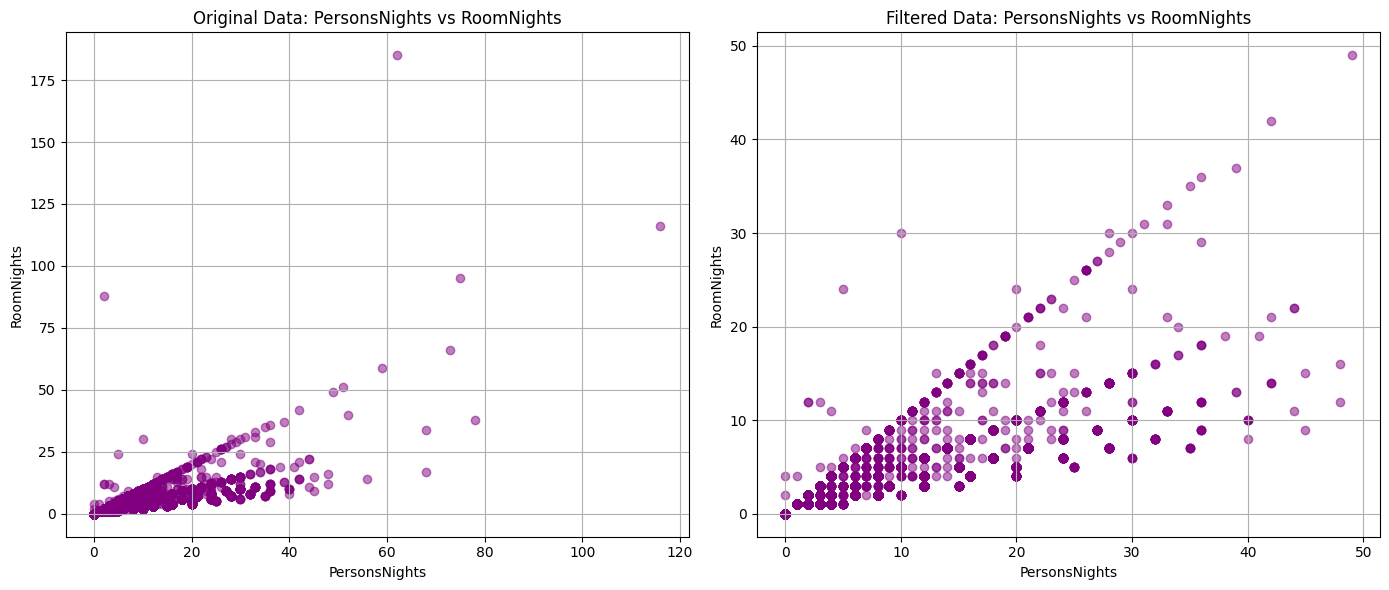

In [31]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

persons_nights = df.select('PersonsNights').toPandas()
room_nights = df.select('RoomNights').toPandas()

# PersonsNights vs RoomNights (scatter plot - original data)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(persons_nights['PersonsNights'], room_nights['RoomNights'], color='purple', alpha=0.5)
plt.title('Original Data: PersonsNights vs RoomNights')
plt.xlabel('PersonsNights')
plt.ylabel('RoomNights')
plt.grid(True)

dff = df.where(col("PersonsNights") < 50).where(col("RoomNights") < 50) # filter data to get a closer look
persons_nights_ = dff.select('PersonsNights').toPandas()
room_nights_ = dff.select('RoomNights').toPandas()

# PersonsNights vs RoomNights (scatter plot - filtered data)
plt.subplot(1, 2, 2)
plt.scatter(persons_nights_['PersonsNights'], room_nights_['RoomNights'], color='purple', alpha=0.5)
plt.title('Filtered Data: PersonsNights vs RoomNights')
plt.xlabel('PersonsNights')
plt.ylabel('RoomNights')
plt.grid(True)

plt.tight_layout()
plt.show()


### Correlation plot

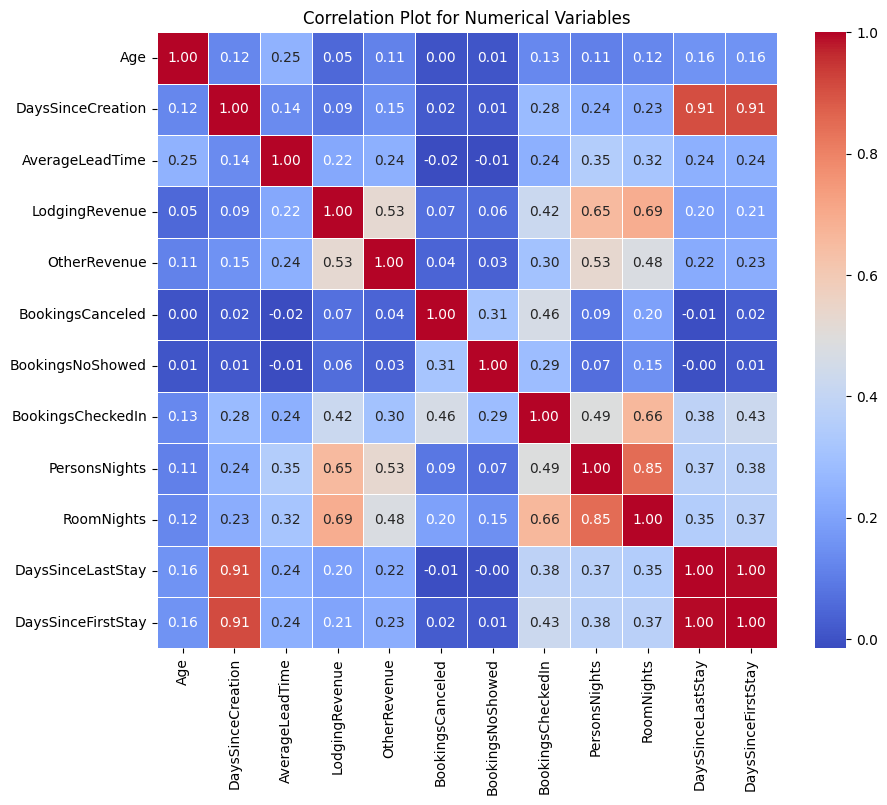

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns = ['Age', 'DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'BookingsCanceled', 
                     'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 'RoomNights', 'DaysSinceLastStay', 
                     'DaysSinceFirstStay']

correlation_matrix = df.select(numerical_columns).toPandas().corr() # correlation matrix

plt.figure(figsize=(10, 8)) # plot corr_matric=x as heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot for Numerical Variables')
plt.show()


- LodgingRevenue has a high positive correlation with PersonsNights and RoomNights which is expected as the lodging cost would go up with more number of people and rooms.
- BookingsCheckIn has a positive correlation with PersonsNight and RoomNights which is again expected.

## Boolean variables

**Types of Floors (High, Middle, Lower) and Rooms (KingBed, Accessible, NoAlcohol, etc,)**

“Stacking” or “melting” is performed on a subset of the dataset containing the boolean columns to convert data from wide format to long format. The columns are stacked into two columns namely ‘Boolean_Column’ and ‘Value’. The 'Boolean_Column' contains the names of the original columns, and the 'Value' contains their corresponding values.

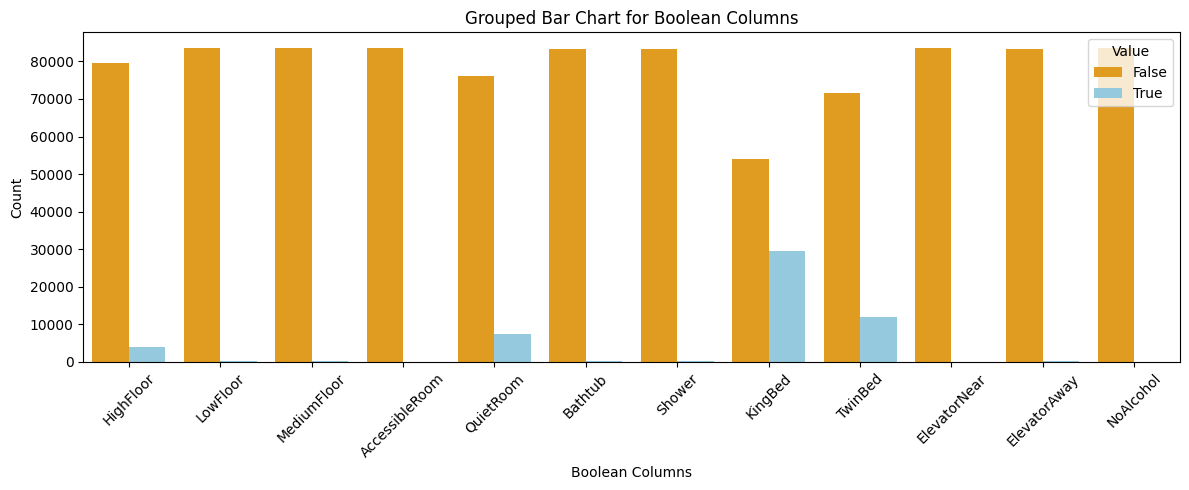

In [33]:
bool_cols = ['HighFloor', 'LowFloor', 'MediumFloor', 'AccessibleRoom', 'QuietRoom', 
             'Bathtub', 'Shower', 'KingBed', 'TwinBed', 'ElevatorNear', 'ElevatorAway', 'NoAlcohol']
bool_df = df.select(bool_cols)

melted_df = bool_df.selectExpr("stack(12, 'HighFloor', HighFloor, 'LowFloor', LowFloor, \
                                    'MediumFloor', MediumFloor, 'AccessibleRoom', AccessibleRoom, \
                                    'QuietRoom', QuietRoom, 'Bathtub', Bathtub, 'Shower', Shower, \
                                    'KingBed', KingBed, 'TwinBed', TwinBed, 'ElevatorNear', ElevatorNear, \
                                    'ElevatorAway', ElevatorAway, 'NoAlcohol', NoAlcohol) \
                                    as (Boolean_Column, Value)") # melt/ stack data from wide to long format 

plt.figure(figsize=(12, 5))
sns.countplot(data=melted_df.toPandas(), x='Boolean_Column', hue='Value', palette={0: 'orange', 1: 'skyblue'})

plt.xlabel('Boolean Columns')
plt.ylabel('Count')
plt.title('Grouped Bar Chart for Boolean Columns')
plt.xticks(rotation=45)

plt.legend(title='Value', labels=['False', 'True'])
plt.tight_layout()
plt.show()


- Majority of the customers do not have a preference denoted by 'False'.
- A few requests can be observed for KingBed, TwinBed, QuietRoom and HighFloor.

## Categorical variables

### Nationality

As seen above in the while describing the data, nationality column contains three letter abbreviations of country names. A new column is created using Spark User Defined Function (Spark UDFs) to map them to their equivalent country names so spatial plottling libraries such as chloropleth maps will be able to infer the locations.

In [12]:
# Dictionary to map country names for abbreviations of available nationality:
country_codes = {
    "AFG": "Afghanistan",
    "ALB": "Albania",
    "DZA": "Algeria",
    "AND": "Andorra",
    "AGO": "Angola",
    "ATG": "Antigua and Barbuda",
    "ARG": "Argentina",
    "ARM": "Armenia",
    "AUS": "Australia",
    "AUT": "Austria",
    "AZE": "Azerbaijan",
    "BHS": "Bahamas",
    "BHR": "Bahrain",
    "BGD": "Bangladesh",
    "BRB": "Barbados",
    "BLR": "Belarus",
    "BEL": "Belgium",
    "BLZ": "Belize",
    "BEN": "Benin",
    "BTN": "Bhutan",
    "BOL": "Bolivia",
    "BIH": "Bosnia and Herzegovina",
    "BWA": "Botswana",
    "BRA": "Brazil",
    "BRN": "Brunei",
    "BGR": "Bulgaria",
    "BFA": "Burkina Faso",
    "BDI": "Burundi",
    "CPV": "Cabo Verde",
    "KHM": "Cambodia",
    "CMR": "Cameroon",
    "CAN": "Canada",
    "CAF": "Central African Republic",
    "TCD": "Chad",
    "CHL": "Chile",
    "CHN": "China",
    "COL": "Colombia",
    "COM": "Comoros",
    "CRI": "Costa Rica",
    "CIV": "Cote d'Ivoire",
    "HRV": "Croatia",
    "CUB": "Cuba",
    "CYP": "Cyprus",
    "CZE": "Czech Republic",
    "COD": "Democratic Republic of the Congo",
    "DNK": "Denmark",
    "DJI": "Djibouti",
    "DMA": "Dominica",
    "DOM": "Dominican Republic",
    "ECU": "Ecuador",
    "EGY": "Egypt",
    "SLV": "El Salvador",
    "GNQ": "Equatorial Guinea",
    "ERI": "Eritrea",
    "EST": "Estonia",
    "SWZ": "Eswatini",
    "ETH": "Ethiopia",
    "FJI": "Fiji",
    "FIN": "Finland",
    "FRA": "France",
    "GAB": "Gabon",
    "GMB": "Gambia",
    "GEO": "Georgia",
    "DEU": "Germany",
    "GHA": "Ghana",
    "GRC": "Greece",
    "GRD": "Grenada",
    "GTM": "Guatemala",
    "GIN": "Guinea",
    "GNB": "Guinea-Bissau",
    "GUY": "Guyana",
    "HTI": "Haiti",
    "HND": "Honduras",
    "HUN": "Hungary",
    "ISL": "Iceland",
    "IND": "India",
    "IDN": "Indonesia",
    "IRN": "Iran",
    "IRQ": "Iraq",
    "IRL": "Ireland",
    "ISR": "Israel",
    "ITA": "Italy",
    "JAM": "Jamaica",
    "JPN": "Japan",
    "JOR": "Jordan",
    "KAZ": "Kazakhstan",
    "KEN": "Kenya",
    "KIR": "Kiribati",
    "KWT": "Kuwait",
    "KGZ": "Kyrgyzstan",
    "LAO": "Laos",
    "LVA": "Latvia",
    "LBN": "Lebanon",
    "LSO": "Lesotho",
    "LBR": "Liberia",
    "LBY": "Libya",
    "LIE": "Liechtenstein",
    "LTU": "Lithuania",
    "LUX": "Luxembourg",
    "MDG": "Madagascar",
    "MWI": "Malawi",
    "MYS": "Malaysia",
    "MDV": "Maldives",
    "MLI": "Mali",
    "MLT": "Malta",
    "MHL": "Marshall Islands",
    "MRT": "Mauritania",
    "MUS": "Mauritius",
    "MEX": "Mexico",
    "FSM": "Micronesia",
    "MDA": "Moldova",
    "MCO": "Monaco",
    "MNG": "Mongolia",
    "MNE": "Montenegro",
    "MAR": "Morocco",
    "MOZ": "Mozambique",
    "MMR": "Myanmar",
    "NAM": "Namibia",
    "NRU": "Nauru",
    "NPL": "Nepal",
    "NLD": "Netherlands",
    "NZL": "New Zealand",
    "NIC": "Nicaragua",
    "NER": "Niger",
    "NGA": "Nigeria",
    "PRK": "North Korea",
    "MKD": "North Macedonia",
    "NOR": "Norway",
    "OMN": "Oman",
    "PAK": "Pakistan",
    "PLW": "Palau",
    "PAN": "Panama",
    "PNG": "Papua New Guinea",
    "PRY": "Paraguay",
    "PER": "Peru",
    "PHL": "Philippines",
    "POL": "Poland",
    "PRT": "Portugal",
    "QAT": "Qatar",
    "COG": "Republic of the Congo",
    "ROU": "Romania",
    "RUS": "Russia",
    "RWA": "Rwanda",
    "KNA": "Saint Kitts and Nevis",
    "LCA": "Saint Lucia",
    "VCT": "Saint Vincent and the Grenadines",
    "WSM": "Samoa",
    "SMR": "San Marino",
    "STP": "Sao Tome and Principe",
    "SAU": "Saudi Arabia",
    "SEN": "Senegal",
    "SRB": "Serbia",
    "SYC": "Seychelles",
    "SLE": "Sierra Leone",
    "SGP": "Singapore",
    "SVK": "Slovakia",
    "SVN": "Slovenia",
    "SLB": "Solomon Islands",
    "SOM": "Somalia",
    "ZAF": "South Africa",
    "KOR": "South Korea",
    "SSD": "South Sudan",
    "ESP": "Spain",
    "LKA": "Sri Lanka",
    "SDN": "Sudan",
    "SUR": "Suriname",
    "SWE": "Sweden",
    "CHE": "Switzerland",
    "SYR": "Syria",
    "TJK": "Tajikistan",
    "TZA": "Tanzania",
    "THA": "Thailand",
    "TLS": "Timor-Leste",
    "TGO": "Togo",
    "TON": "Tonga",
    "TTO": "Trinidad and Tobago",
    "TUN": "Tunisia",
    "TUR": "Turkey",
    "TKM": "Turkmenistan",
    "TUV": "Tuvalu",
    "TWN": "Taiwan",
    "UGA": "Uganda",
    "UKR": "Ukraine",
    "ARE": "United Arab Emirates",
    "GBR": "United Kingdom",
    "USA": "United States",
    "URY": "Uruguay",
    "UZB": "Uzbekistan",
    "VUT": "Vanuatu",
    "VAT": "Vatican City",
    "VEN": "Venezuela",
    "VNM": "Vietnam",
    "YEM": "Yemen",
    "ZMB": "Zambia",
    "ZWE": "Zimbabwe"
}

In [13]:
from pyspark.sql.functions import udf

# UDF to map country abbreviation to country names
@udf(StringType())
def map_country_code(country_code):
    return country_codes.get(country_code, "Unknown")

df = df.withColumn("Country", map_country_code(df["Nationality"])) # create new column for 'Country'

other_columns = [col for col in df.columns if col != "Country"]
new_columns = other_columns[:2] + ["Country"] + other_columns[2:] # reorder columns as desired

df = df.select(new_columns)

df.show(5)

+---+-----------+--------+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+--------------------+--------------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+
| ID|Nationality| Country|Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay| DistributionChannel|       MarketSegment|HighFloor|LowFloor|AccessibleRoom|MediumFloor|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|QuietRoom|
+---+-----------+--------+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+--------------------+-------------------

Countries that did not have a reference in the mapping dictionary will be named as "Unknown". If only a few countries fall under this category, they can be removed from further analysis.

In [36]:
from pyspark.sql.functions import col

unknown_countries = df.filter((col("Country") == "Unknown"))
unknown_countries.count()

unknown_countries.groupBy("Nationality").count().orderBy("count", ascending=False).show(10)

+-----------+-----+
|Nationality|count|
+-----------+-----+
|        ATF|   10|
|        HKG|    4|
|        ABW|    3|
|        ATA|    3|
|        AIA|    3|
|        SPM|    3|
|        GIB|    3|
|        ASM|    3|
|        UMI|    3|
|        PRI|    2|
+-----------+-----+
only showing top 10 rows



In [37]:
# Top 5 countries with the most number of customers
country = df.groupBy("Country").count().orderBy("count", ascending=False)
country.show(5)

+--------------+-----+
|       Country|count|
+--------------+-----+
|        France|12422|
|      Portugal|11597|
|       Germany|10232|
|United Kingdom| 8656|
|         Spain| 4902|
+--------------+-----+
only showing top 5 rows



In [39]:
pd_country = country.toPandas()
pd_country.set_index("Country", inplace=True)

# Chloropleth map
fig = go.Figure(go.Choropleth(
    locations=pd_country.index,  # country
    z=pd_country['count'], # value
    locationmode='country names',
    colorscale='Reds',
    colorbar_title='Counts',
))

fig.update_layout(
    title_text='Customer distribution by Country',
    geo=dict(
        showcoastlines=True,
    ),
    width=800,
    height=600,
)

fig.show()

### Market segment and Distribution channel

- Distribution channel is the medium through which the bookings are made such as direct, electronic distribution, etc.
- Market segment to the market category upon which the customers are classified such as aviation, travel agent, groups, etc.

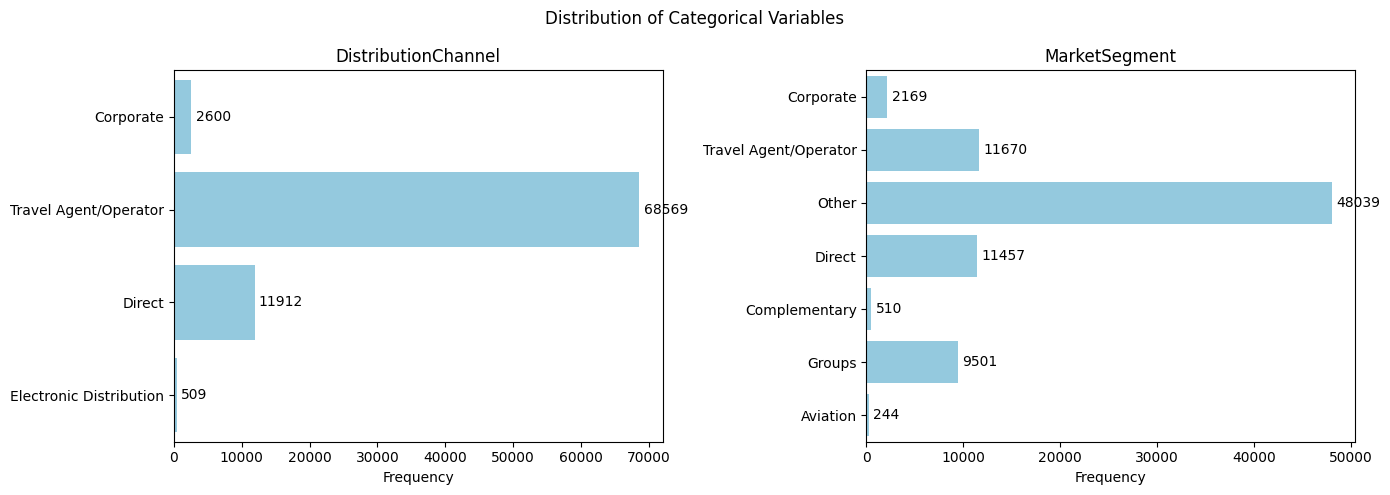

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(['DistributionChannel', 'MarketSegment']):
    sns.countplot(data=df.toPandas(), y=col, color='skyblue', ax=axes[i], legend=False)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x')

    for p in axes[i].patches:
        width = p.get_width()
        axes[i].annotate(f'{round(width)}', 
                         xy=(width, p.get_y() + p.get_height() / 2), 
                         xytext=(3, 0), 
                         textcoords='offset points', 
                         ha='left', 
                         va='center')
        
plt.suptitle('Distribution of Categorical Variables')
plt.tight_layout()
plt.show()

- About 70,000 customers booked via the ‘Travel Agent’ distribution channel are split into the market segments ‘Other’, ‘Travel Agent’, and ‘Direct’ recording about 50,000, 11,000 and 10,000 customers respectively.
- Similarly customers of the ‘Corporate’ channel can be observed to be split into the segments ‘Corporate’ and ‘Aviation'.

### Market Segment Analysis (average)

In [14]:
from pyspark.sql.functions import regexp_replace

df = df.withColumn("MarketSegment", regexp_replace("MarketSegment", "Travel Agent/Operator", "Travel Agent"))

# filter columns that would make sense for an analysis using the 'average' metric
ms_avg = df.select(['MarketSegment', 'Age', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'PersonsNights', 'RoomNights'])

ms_avg = ms_avg.groupby('MarketSegment').mean() # aggregate data and calculate mean

from pyspark.sql.functions import regexp_replace

for column_name in ms_avg.columns:
    if column_name != "MarketSegment":
        ms_avg = ms_avg.withColumnRenamed(column_name, column_name.replace("avg(", "").replace(")", "")) # rename columns using regex

ms_avg.show()

+-------------+------------------+------------------+------------------+------------------+------------------+------------------+
|MarketSegment|               Age|   AverageLeadTime|    LodgingRevenue|      OtherRevenue|     PersonsNights|        RoomNights|
+-------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Complementary| 41.86470588235294| 19.99411764705882|22.810313725490197|16.794686274509807|3.2411764705882353|1.9627450980392156|
|     Aviation| 50.74180327868852| 5.864754098360656| 533.9850409836066| 80.84364754098361| 5.127049180327869| 4.991803278688525|
|        Other| 43.71575178500802| 59.68069693374134|316.82614729698844| 66.74471325381457| 4.888798684402256|2.3256728907762443|
|       Direct|42.763899799249366|43.690494893951296| 316.7641031683688|  68.9196255564284| 4.318495243082832|2.0901632189927555|
| Travel Agent| 49.03384747215081| 99.86649528706084| 229.2962553556129| 74.89342930591255

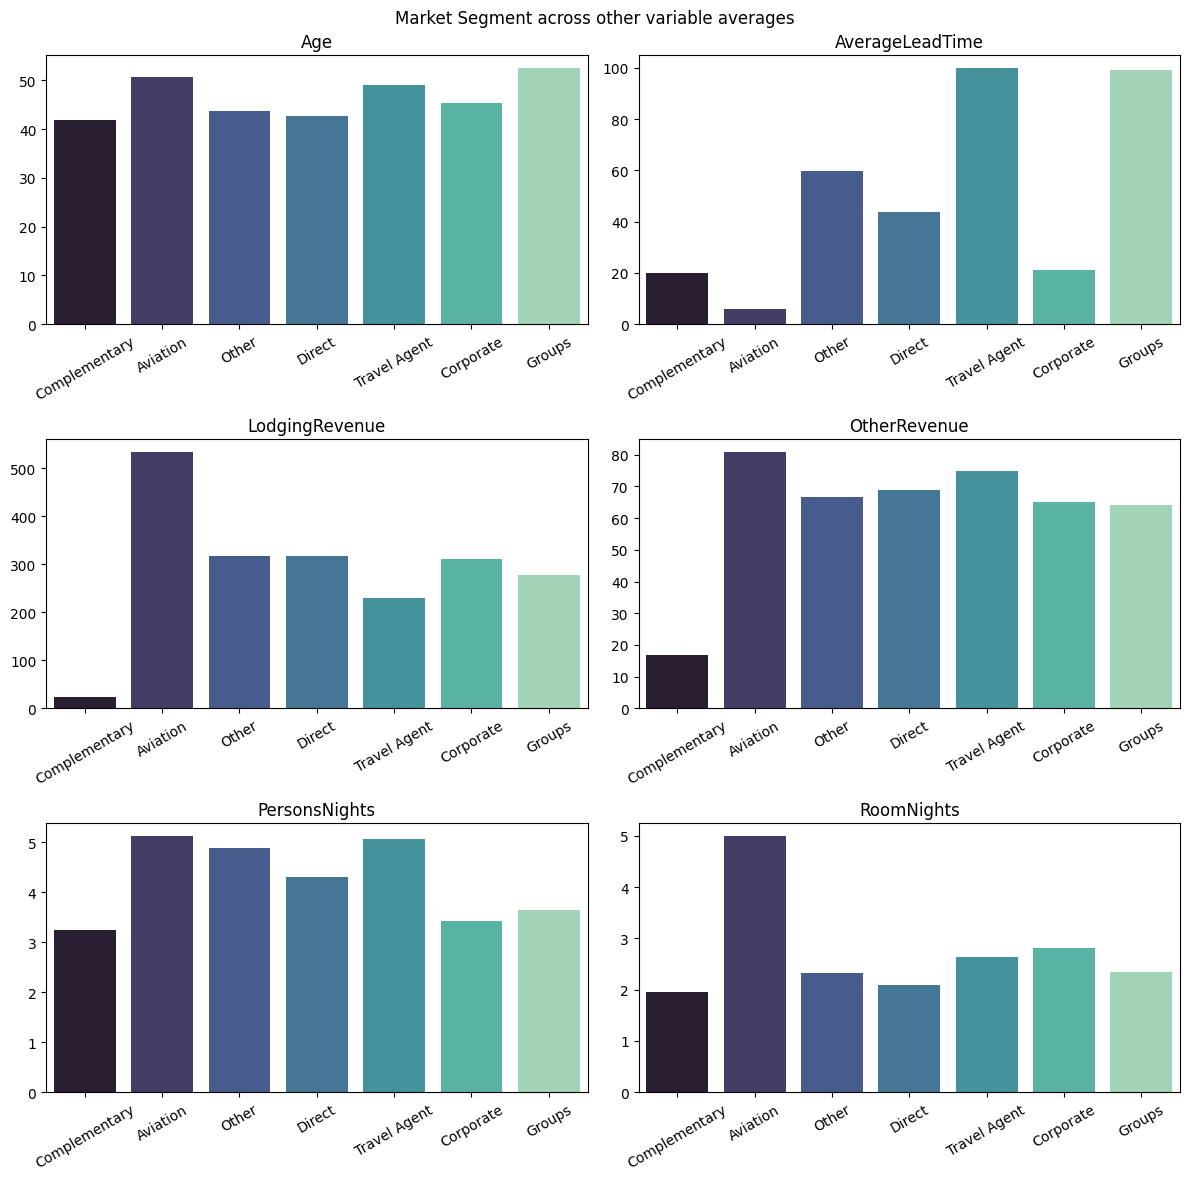

In [42]:
# Plotting
pd_ms_avg = ms_avg.toPandas()
pd_ms_avg.set_index("MarketSegment", inplace=True)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, x in enumerate(pd_ms_avg.columns):
    sns.barplot(x='MarketSegment', y=pd_ms_avg[x], data=pd_ms_avg, hue=pd_ms_avg.index, ax=axes[i], dodge=False, legend=False, palette = 'mako')
    axes[i].tick_params(axis='x', rotation=30)
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(x)

plt.suptitle('Market Segment across other variable averages')
plt.tight_layout()
plt.show()


- Age does not seem vary among the segments.
- Travel Agent and Group tend to book well in advance (almost 100 days).
- Aviation bookings bring higher LodgingRevenue and take up more rooms indicated by RoomNights.
- Segments do not vary much among OtherRevenue and PersonsNights (excluding Complimentary)

### Market Segment Analysis (Sum)

In [43]:
from pyspark.sql.functions import regexp_replace

# filter columns that would make sense for an analysis using the 'sum' metric
ms_sum = df.select(['MarketSegment', 'LodgingRevenue', 'OtherRevenue', 'BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 'RoomNights', 'HighFloor', 'LowFloor', 'MediumFloor', 'AccessibleRoom', 'QuietRoom', 'Bathtub', 'Shower', 'Crib', 'KingBed', 'TwinBed', 'ElevatorNear', 'ElevatorAway', 'NoAlcohol'])

ms_sum = ms_sum.groupby('MarketSegment').sum() # aggregate and calculate mean

from pyspark.sql.functions import regexp_replace

for column_name in ms_sum.columns:
    if column_name != "MarketSegment":
        ms_sum = ms_sum.withColumnRenamed(column_name, column_name.replace("sum(", "").replace(")", "")) # rename using regex

ms_sum.show()

+-------------+--------------------+------------------+----------------+----------------+-----------------+-------------+----------+---------+--------+-----------+--------------+---------+-------+------+----+-------+-------+------------+------------+---------+
|MarketSegment|      LodgingRevenue|      OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|HighFloor|LowFloor|MediumFloor|AccessibleRoom|QuietRoom|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|
+-------------+--------------------+------------------+----------------+----------------+-----------------+-------------+----------+---------+--------+-----------+--------------+---------+-------+------+----+-------+-------+------------+------------+---------+
|Complementary|            11633.26|           8565.29|              19|               0|              580|         1653|      1001|       13|       0|          1|             0|        2|      3|     0|  17|    166| 

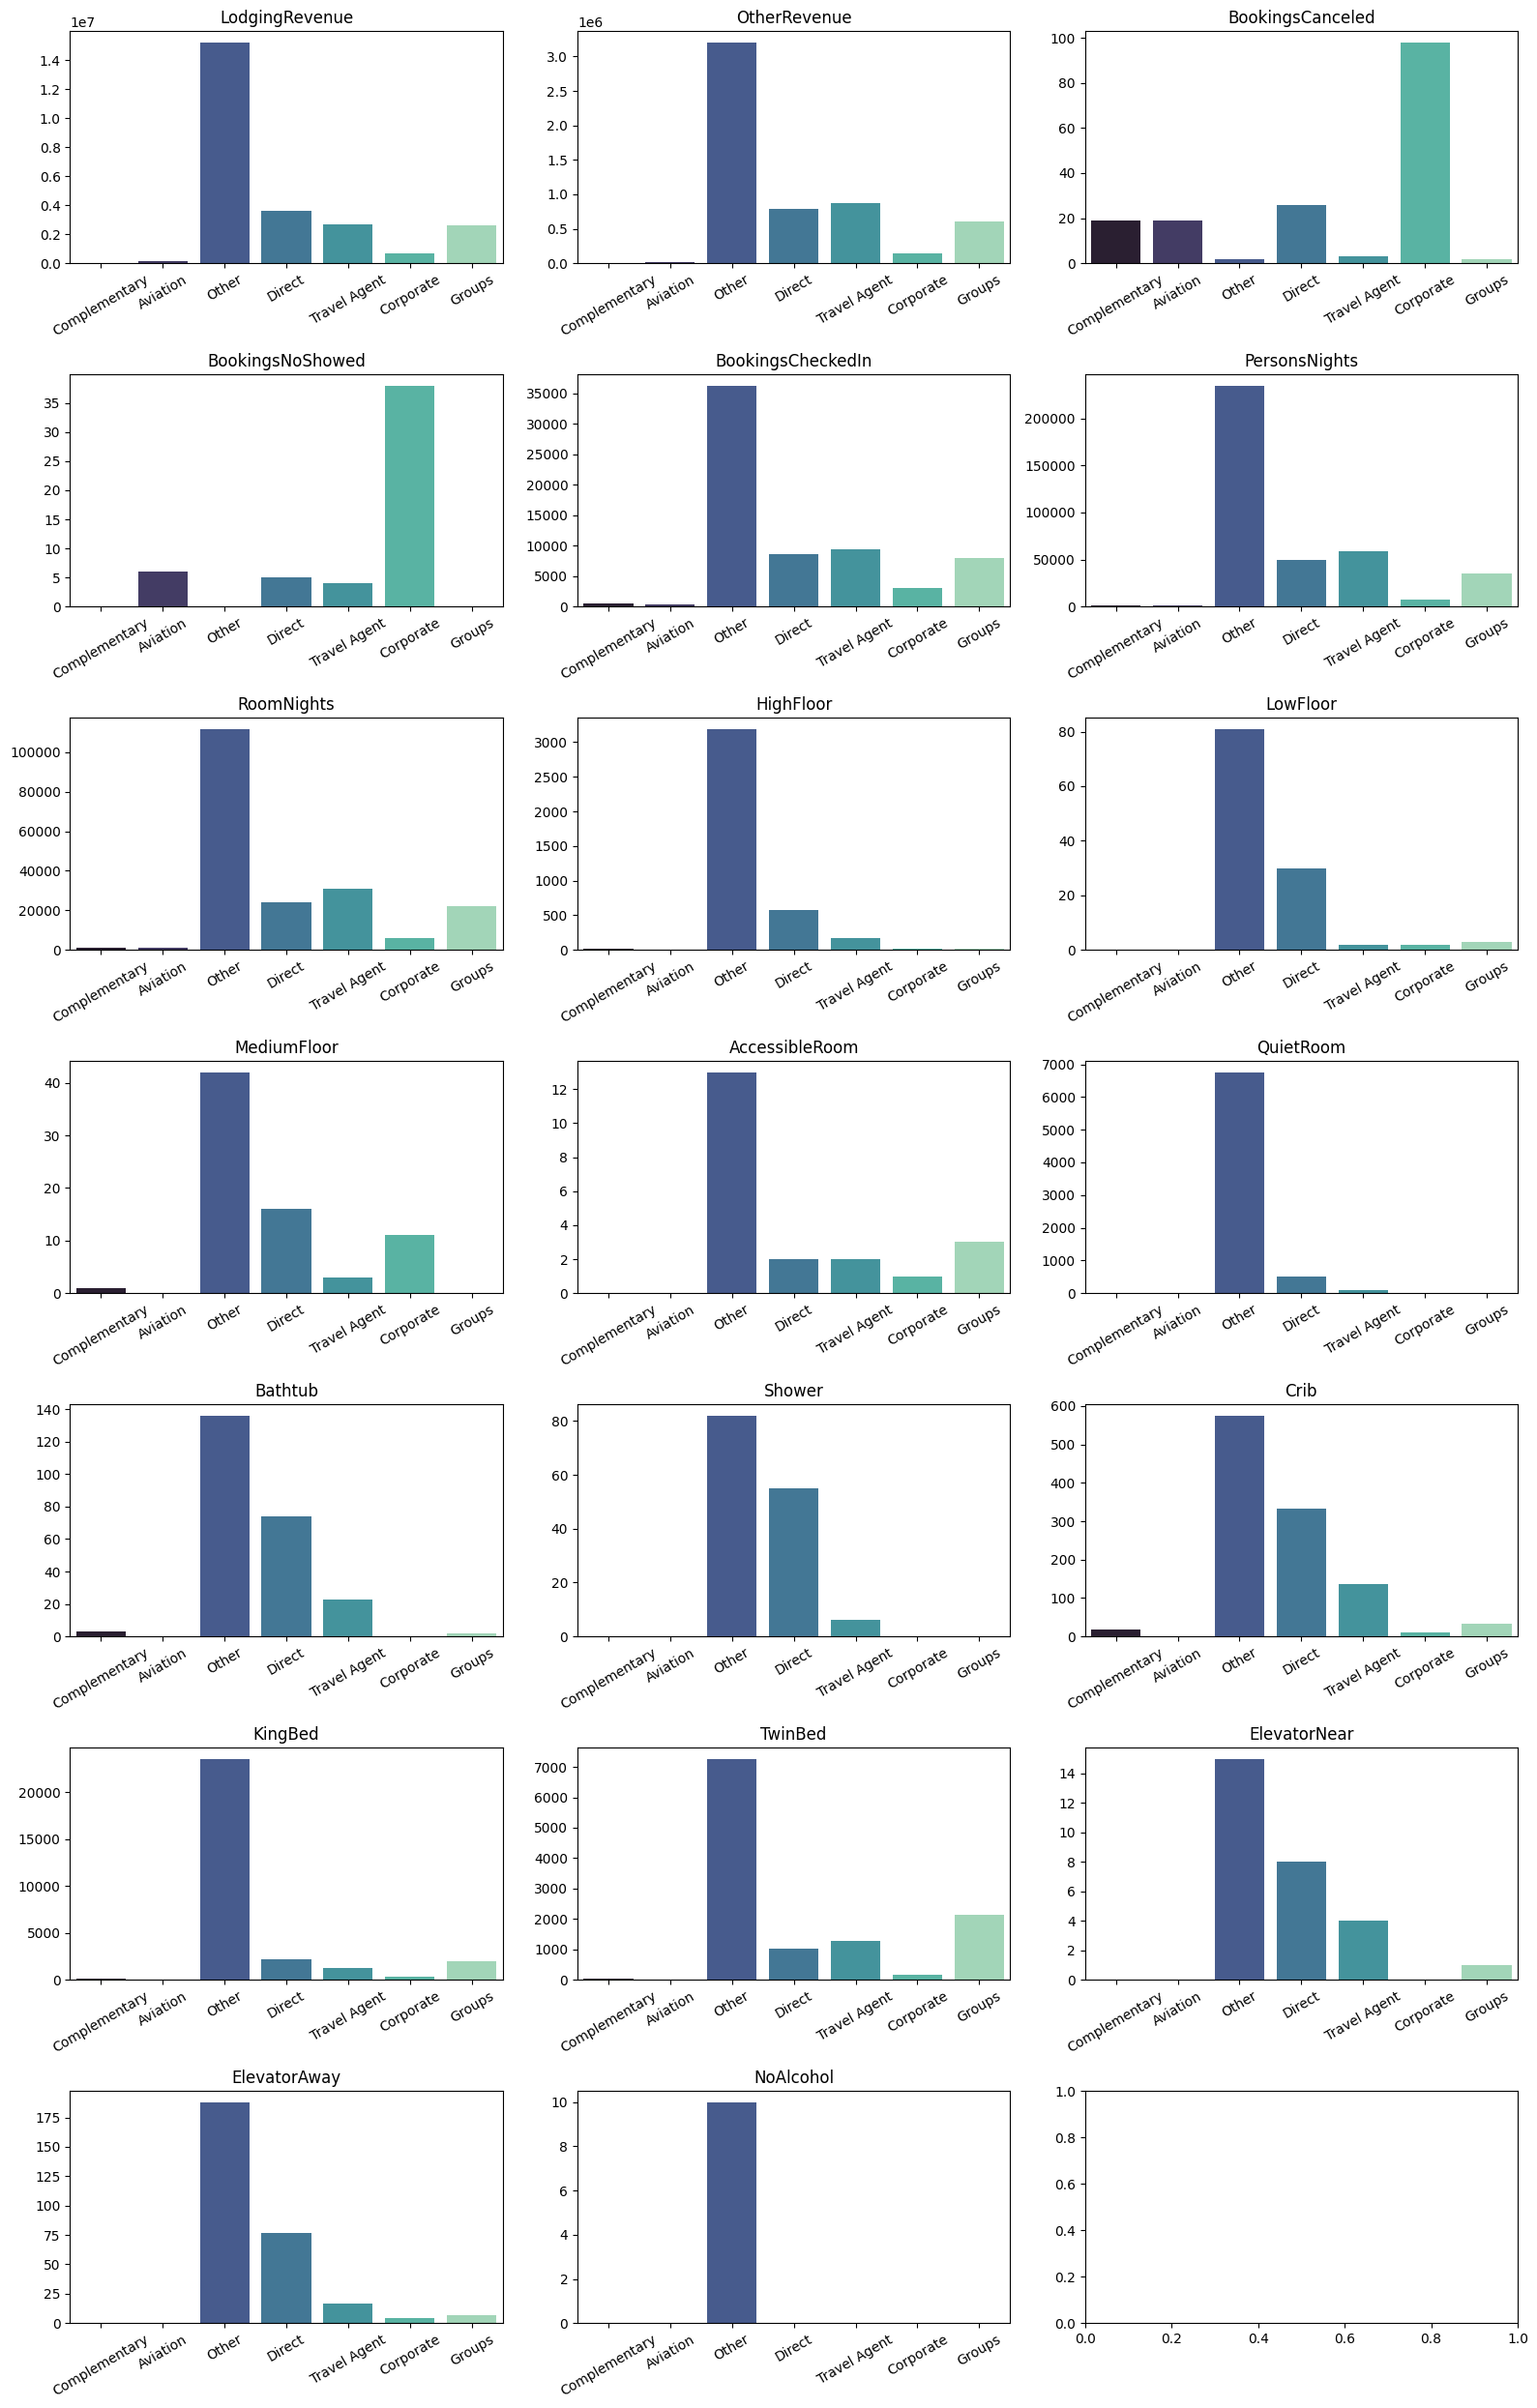

In [44]:
pd_ms_sum = ms_sum.toPandas()
pd_ms_sum.set_index("MarketSegment", inplace=True)

fig, axes = plt.subplots(7, 3, figsize=(16, 25))

axes = axes.flatten()

for i, x in enumerate(pd_ms_sum.columns):
    sns.barplot(x='MarketSegment', y=pd_ms_sum[x], data=pd_ms_sum, hue=pd_ms_sum.index, ax=axes[i], dodge=False, legend=False, palette = 'mako')
    axes[i].tick_params(axis='x', rotation=30)
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(x)

plt.tight_layout()
plt.show()


- Direct, Travel Agent and Others generate higher Revenue.
- Booking cancellations and no show are predominantly associated with Corporate.

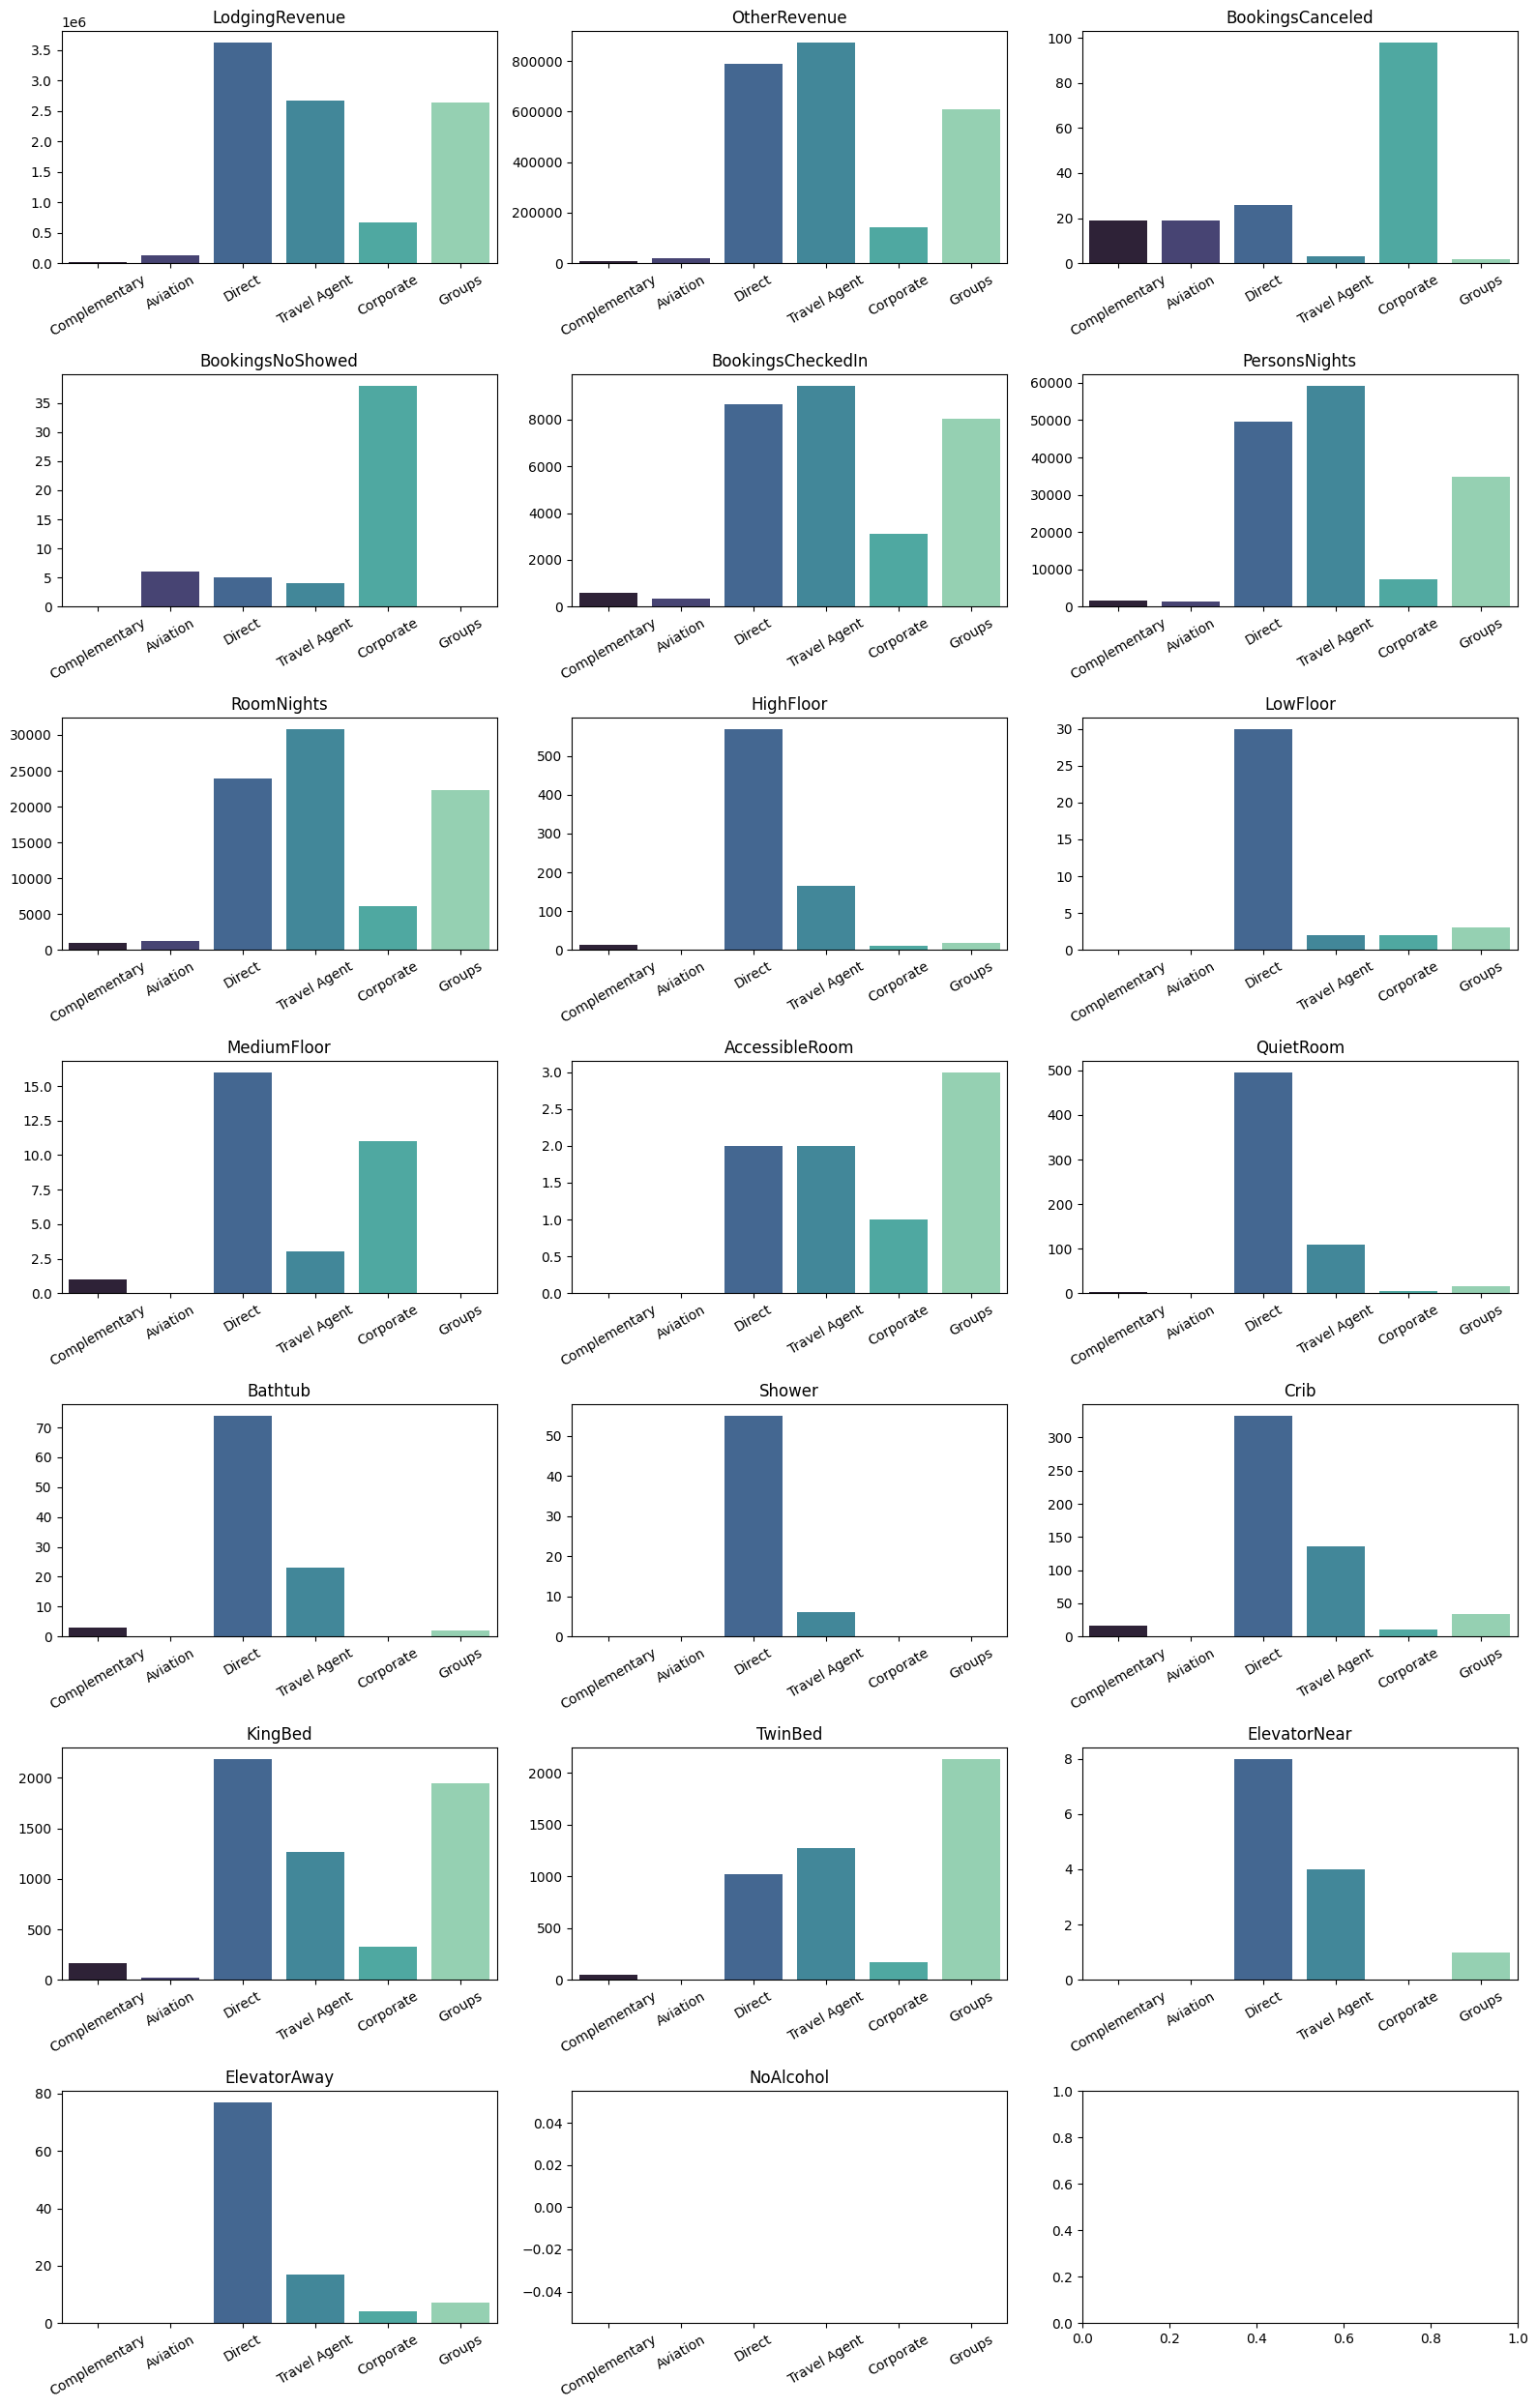

In [45]:
# # Dropping 'Others' to see the distribution of the remaining segments
# pd_ms_sum = pd_ms_sum.drop(index='Other')

# # Create subplots with 2 rows and 3 columns
# fig, axes = plt.subplots(7, 3, figsize=(16, 25))

# # Flatten the axes array to iterate over them
# axes = axes.flatten()

# # Iterate over each column and plot
# for i, x in enumerate(pd_ms_sum.columns):
#     # Plot on the current subplot with default seaborn palette
#     sns.barplot(x='MarketSegment', y=pd_ms_sum[x], data=pd_ms_sum, hue=pd_ms_sum.index, ax=axes[i], dodge=False, legend=False, palette = 'mako')
    
#     # Rotate x-axis tick labels
#     axes[i].tick_params(axis='x', rotation=30)
    
#     # Add labels and title
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')
#     axes[i].set_title(x)

# # plt.suptitle('Market Segment across other variable sum')
# plt.tight_layout()
# plt.show()


### Distribution Channel Analysis (average)

In [15]:
from pyspark.sql.functions import regexp_replace

df = df.withColumn("DistributionChannel", regexp_replace("DistributionChannel", "Travel Agent/Operator", "Travel Agent"))
df = df.withColumn("DistributionChannel", regexp_replace("DistributionChannel", "Electronic Distribution", "Electronic"))

In [47]:
dc_avg = df.select(['DistributionChannel', 'Age', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'PersonsNights', 'RoomNights'])
dc_avg = dc_avg.groupby('DistributionChannel').mean()
dc_avg.show()

+-------------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+
|DistributionChannel|          avg(Age)|avg(AverageLeadTime)|avg(LodgingRevenue)|avg(OtherRevenue)|avg(PersonsNights)|   avg(RoomNights)|
+-------------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+
|             Direct| 42.74479516453996|   42.72070181329752| 302.83532824042993|66.09035678307589|  4.25260241773002|2.0570852921423772|
|       Travel Agent|45.804868089078155|   71.90338199477898| 297.15492540360793|68.12681911651036| 4.776079569484753|2.3883095859645027|
|          Corporate|46.737307692307695|  32.003076923076925| 326.37633076923083|66.92672307692308| 3.568846153846154|3.0034615384615386|
|         Electronic| 42.88801571709234|  21.387033398821217| 285.45675834970535|33.61465618860511| 2.345776031434185|2.1080550098231825|
+-------------------+-------------

In [48]:
from pyspark.sql.functions import regexp_replace

for column_name in dc_avg.columns:
    if column_name != "DistributionChannel":
        dc_avg = dc_avg.withColumnRenamed(column_name, column_name.replace("avg(", "").replace(")", ""))
        
dc_avg.show()

+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|DistributionChannel|               Age|   AverageLeadTime|    LodgingRevenue|     OtherRevenue|    PersonsNights|        RoomNights|
+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|             Direct| 42.74479516453996| 42.72070181329752|302.83532824042993|66.09035678307589| 4.25260241773002|2.0570852921423772|
|       Travel Agent|45.804868089078155| 71.90338199477898|297.15492540360793|68.12681911651036|4.776079569484753|2.3883095859645027|
|          Corporate|46.737307692307695|32.003076923076925|326.37633076923083|66.92672307692308|3.568846153846154|3.0034615384615386|
|         Electronic| 42.88801571709234|21.387033398821217|285.45675834970535|33.61465618860511|2.345776031434185|2.1080550098231825|
+-------------------+------------------+------------------+---

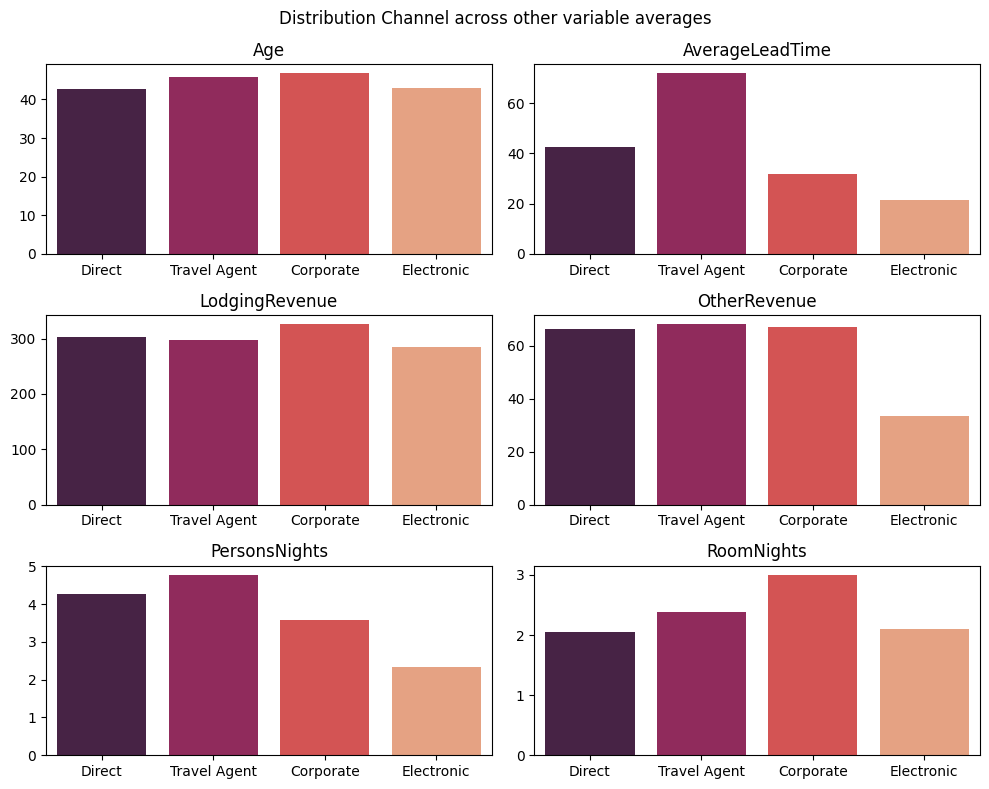

In [50]:
pd_dc_avg = dc_avg.toPandas()
pd_dc_avg.set_index("DistributionChannel", inplace=True)

fig, axes = plt.subplots(3, 2, figsize=(10, 8))

axes = axes.flatten()

for i, x in enumerate(pd_dc_avg.columns):
    sns.barplot(x='DistributionChannel', y=pd_dc_avg[x], data=pd_dc_avg, hue=pd_dc_avg.index, ax=axes[i], dodge=False, legend=False, palette = 'rocket')
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(x)

plt.suptitle('Distribution Channel across other variable averages')
plt.tight_layout()
plt.show()

- Travel Agent bookings are made in advance
- Rooms held by Corporate are comparatively higher
- Electronic channel bookings contribute to lower OtherRevenue and account for lesser PersonsNights.


### Distribution Channel Analysis (sum)

In [51]:
from pyspark.sql.functions import regexp_replace

dc_sum = df.select(['DistributionChannel', 'LodgingRevenue', 'OtherRevenue', 'BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 'RoomNights', 'HighFloor', 'LowFloor', 'MediumFloor', 'AccessibleRoom', 'QuietRoom', 'Bathtub', 'Shower', 'Crib', 'KingBed', 'TwinBed', 'ElevatorNear', 'ElevatorAway', 'NoAlcohol'])
dc_sum = dc_sum.groupby('DistributionChannel').sum()

from pyspark.sql.functions import regexp_replace

for column_name in dc_sum.columns:
    if column_name != "DistributionChannel":
        dc_sum = dc_sum.withColumnRenamed(column_name, column_name.replace("sum(", "").replace(")", ""))

dc_sum.show()

+-------------------+-------------------+-----------------+----------------+----------------+-----------------+-------------+----------+---------+--------+-----------+--------------+---------+-------+------+----+-------+-------+------------+------------+---------+
|DistributionChannel|     LodgingRevenue|     OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|HighFloor|LowFloor|MediumFloor|AccessibleRoom|QuietRoom|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|
+-------------------+-------------------+-----------------+----------------+----------------+-----------------+-------------+----------+---------+--------+-----------+--------------+---------+-------+------+----+-------+-------+------------+------------+---------+
|             Direct| 3607374.4300000016|787268.3300000001|              40|               6|             9121|        50657|     24504|      575|      28|         13|             2|      502|     74|    5

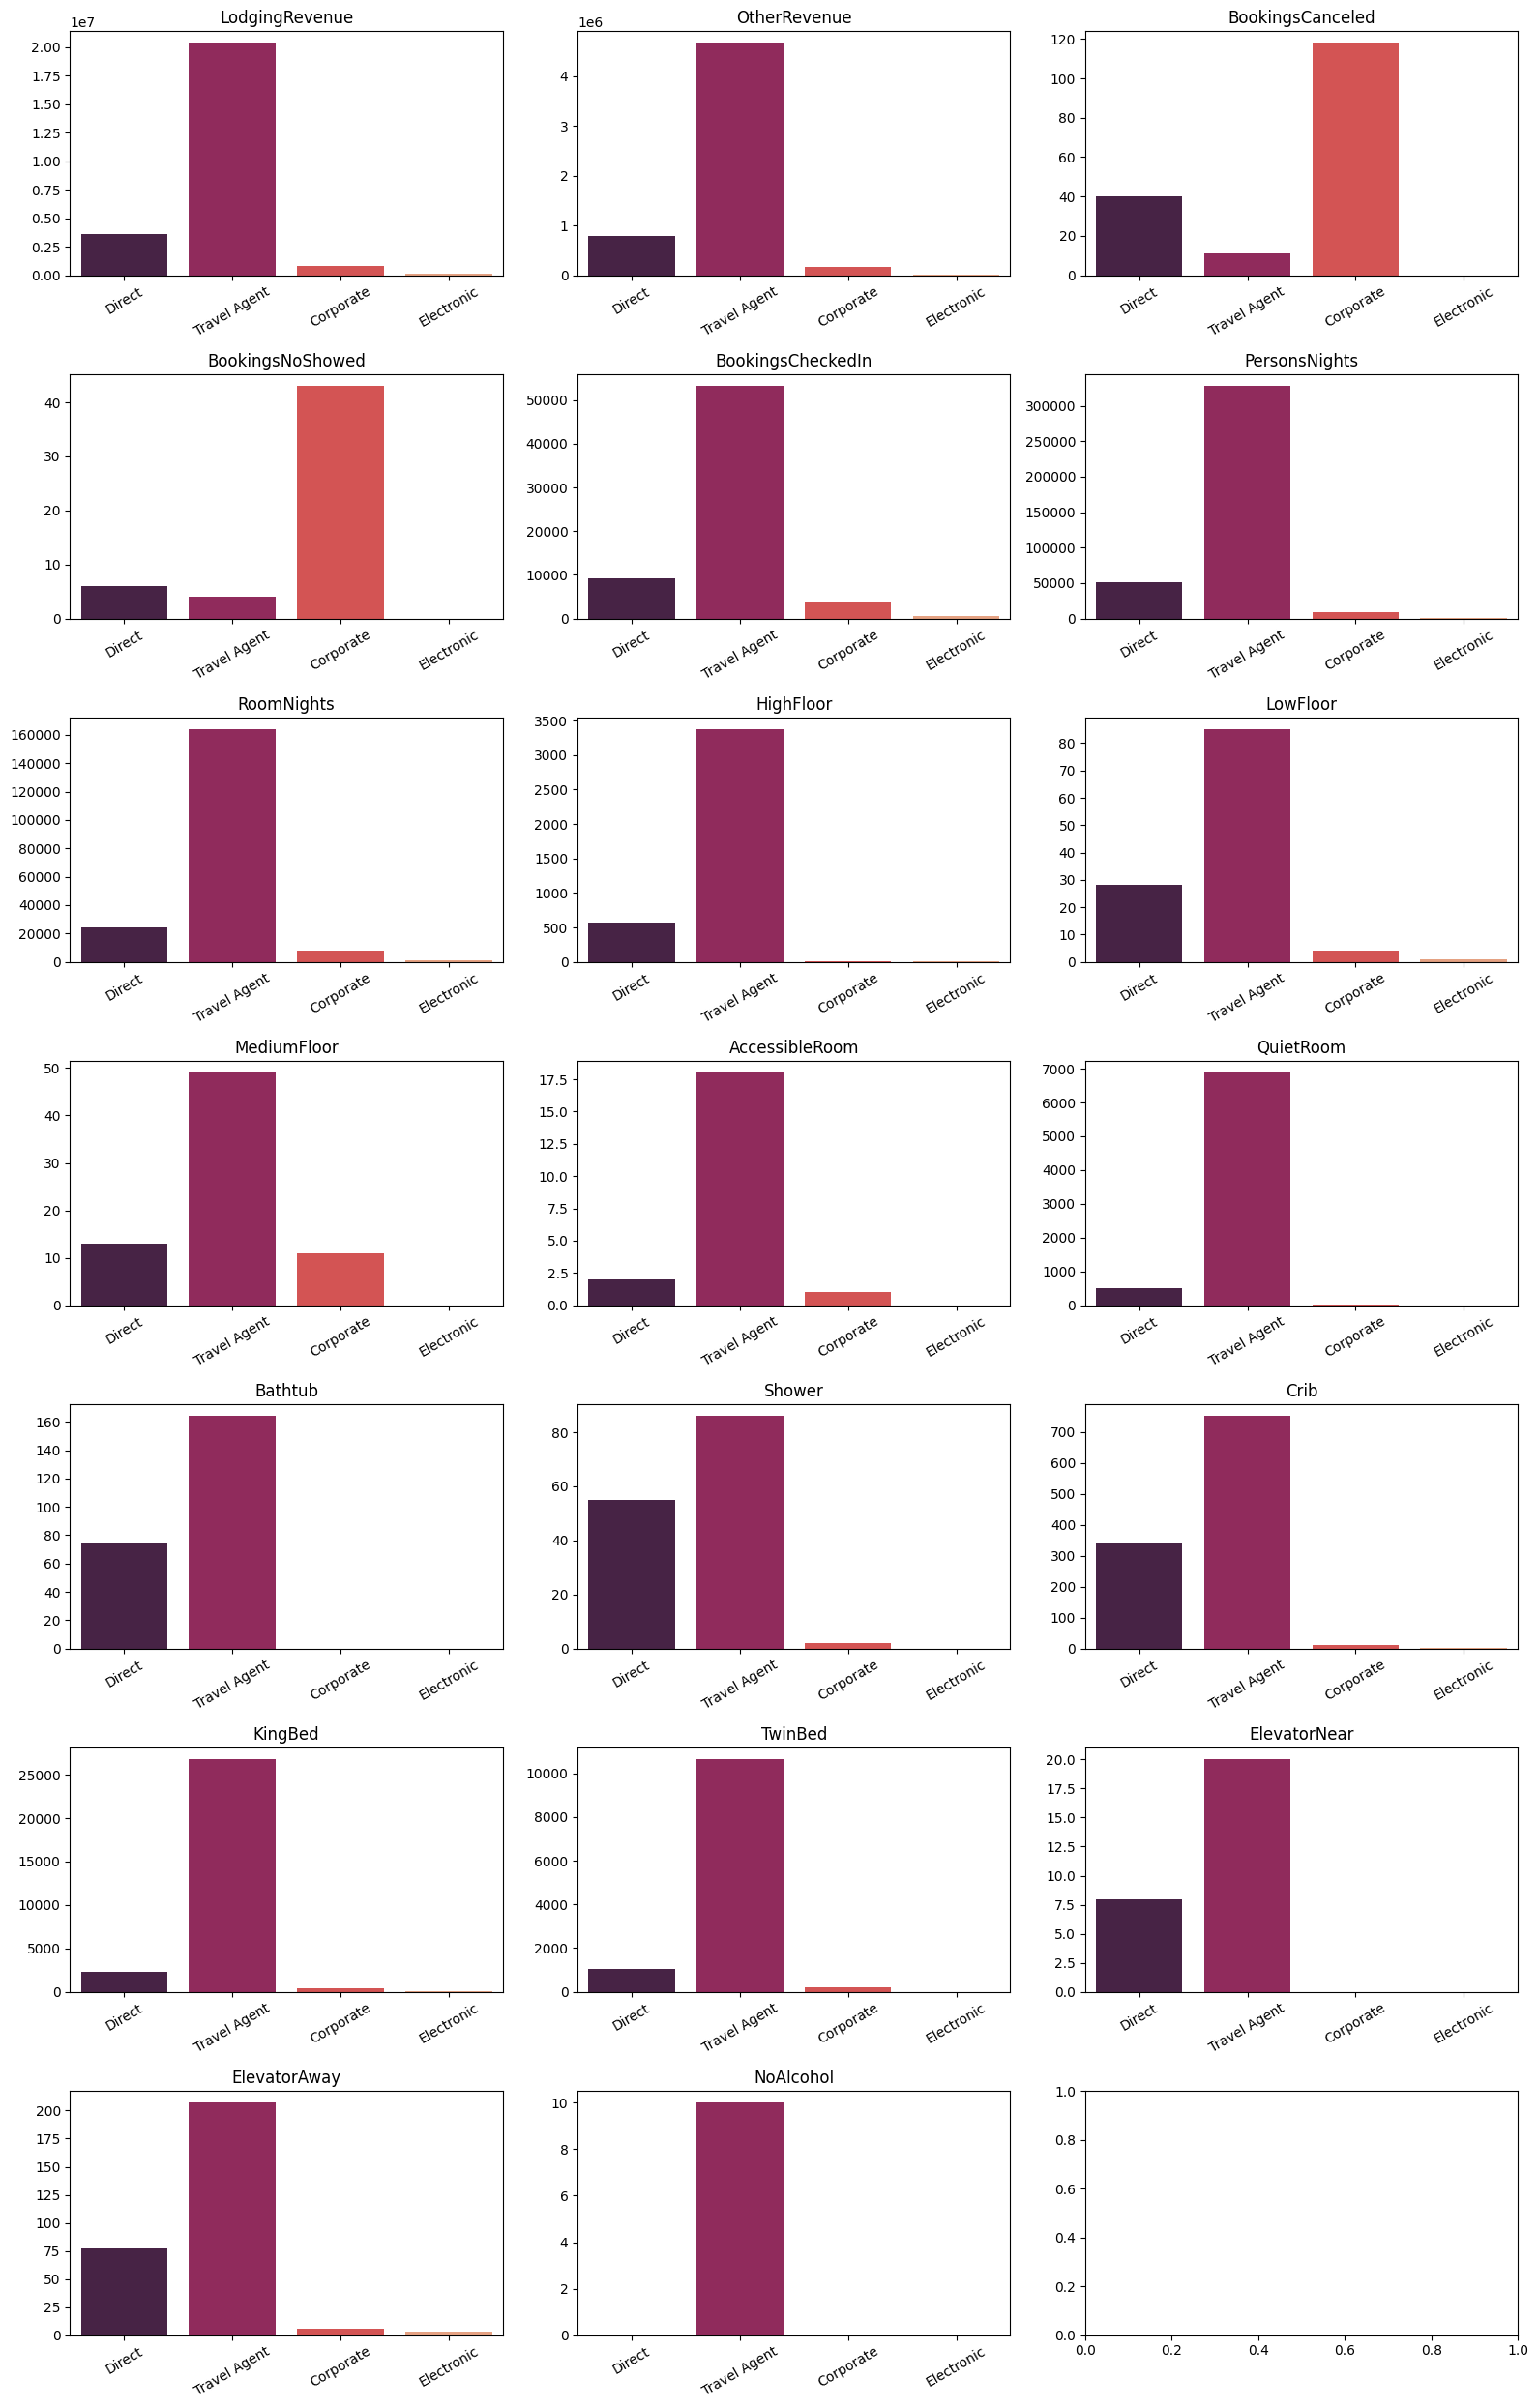

In [52]:
pd_dc_sum = dc_sum.toPandas()
pd_dc_sum.set_index("DistributionChannel", inplace=True)

fig, axes = plt.subplots(7, 3, figsize=(16, 25))

axes = axes.flatten()

for i, x in enumerate(pd_dc_sum.columns):
    sns.barplot(x='DistributionChannel', y=pd_dc_sum[x], data=pd_dc_sum, hue=pd_dc_sum.index, ax=axes[i], dodge=False, legend=False, palette = 'rocket')
    
    axes[i].tick_params(axis='x', rotation=30)
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(x)

plt.tight_layout()
plt.show()


- The results are almost similar to that of Market Segment where cancellations and no shows are associated with Corporate
- A few special requests such as Bathtub, Showe, Crib are made by Direct next to Travel Agent.

# Segmentation using MlLib

Transform string variables to dummies

In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

cols_to_index = ['Nationality', 'DistributionChannel','MarketSegment'] # define columns to be indexed and encoded
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in cols_to_index] # create a list of StringIndexer stages
pipeline = Pipeline(stages=indexers) # define pipeline with both indexing and encoding stages
pipeline_model = pipeline.fit(df) # fit pipeline to data
df_transformed = pipeline_model.transform(df) # transform data using pipeline
df_transformed.select('MarketSegment','MarketSegment_index').distinct().show(20)
df_transformed = df_transformed.drop(*cols_to_index, *['Country']) # drop original string columns
df_transformed.show()

+-------------+-------------------+
|MarketSegment|MarketSegment_index|
+-------------+-------------------+
|     Aviation|                6.0|
|       Groups|                3.0|
|       Direct|                2.0|
|    Corporate|                4.0|
| Travel Agent|                1.0|
|        Other|                0.0|
|Complementary|                5.0|
+-------------+-------------------+

+---+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+-----------------+-------------------------+-------------------+
| ID|Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay|HighFloor|LowFloor|AccessibleRoom|Medium

### K - Means Clustering

Find the cluster number--Elbow Curve

+---+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+-----------------+-------------------------+-------------------+---------------------------------------------------------------------------------------------------------------------+
|ID |Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay|HighFloor|LowFloor|AccessibleRoom|MediumFloor|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|QuietRoom|Nationality_index|DistributionChannel_index|MarketSegment_index|features                                                                                                             |
+---+---

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|standardized                                                                                                                                                                                                                                                                                                                              |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|

24/04/24 10:23:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/24 10:23:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


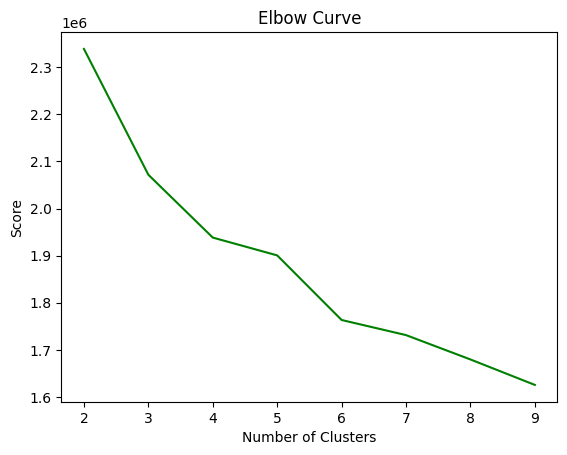

Optimal number of clusters: 9


In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble = VectorAssembler(inputCols=df_transformed.columns, outputCol='features') # assemble features
assembled_data = assemble.transform(df_transformed)

assembled_data.show(5, truncate=False) # display transformed df

from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.select('standardized').show(2,truncate=False)

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

seed = 42

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i,seed=seed)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost,color='green')
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

optimal_k = df_cost.loc[df_cost.cost.idxmin(), 'cluster']
print("Optimal number of clusters:", optimal_k)

K = 6

In [18]:
KMeans_algo=KMeans(featuresCol='standardized', k=6)
KMeans_fit=KMeans_algo.fit(data_scale_output)
KMeans_fit.setPredictionCol("Kmeans_Preds")
km_preds=KMeans_fit.transform(data_scale_output)

km_preds.show(15,0)

+---+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+-----------------+-------------------------+-------------------+---------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|ID |Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLas

Analysis of Cluster

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: The palette list has more values (105) than needed (6), which may not be intended.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


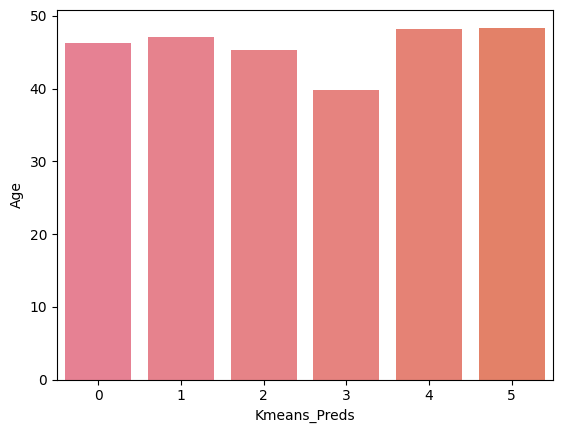

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: The palette list has more values (10257) than needed (6), which may not be intended.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


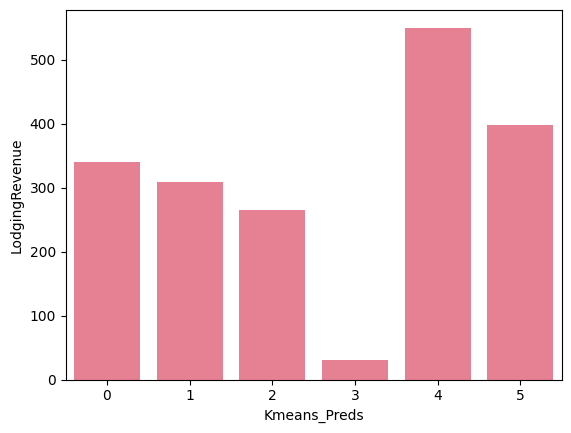

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: The palette list has more values (4490) than needed (6), which may not be intended.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


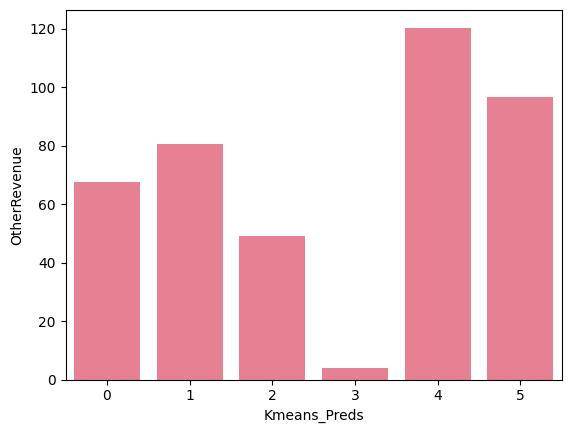

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: 
The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


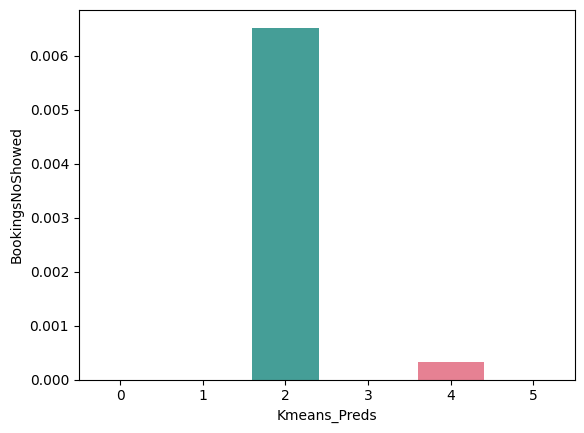

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


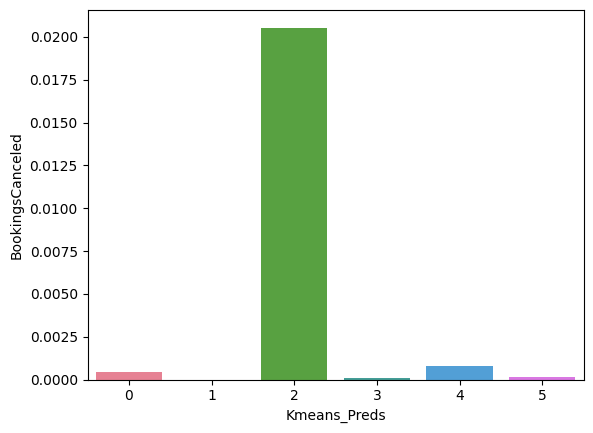

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: The palette list has more values (29) than needed (6), which may not be intended.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


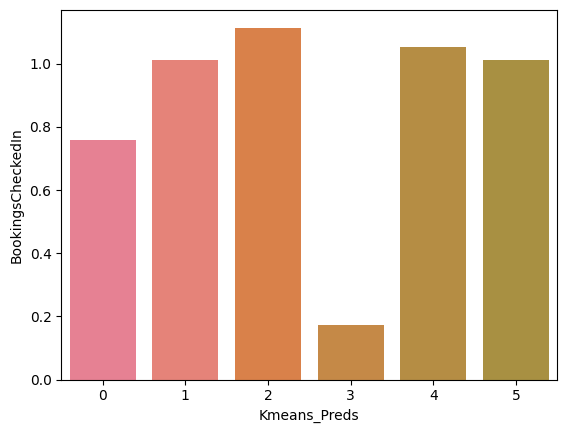

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: The palette list has more values (56) than needed (6), which may not be intended.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


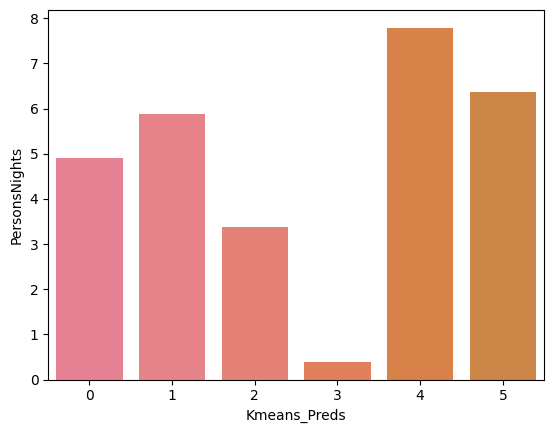

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


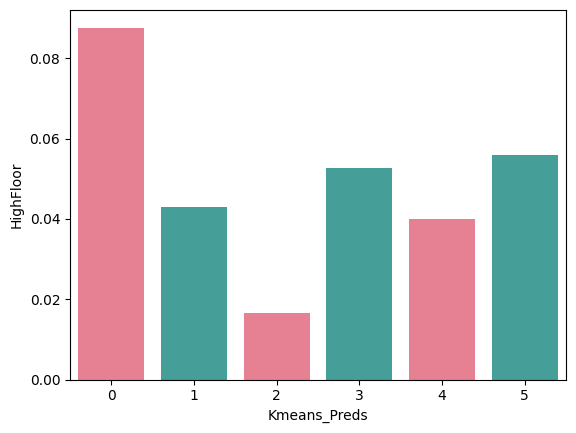

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


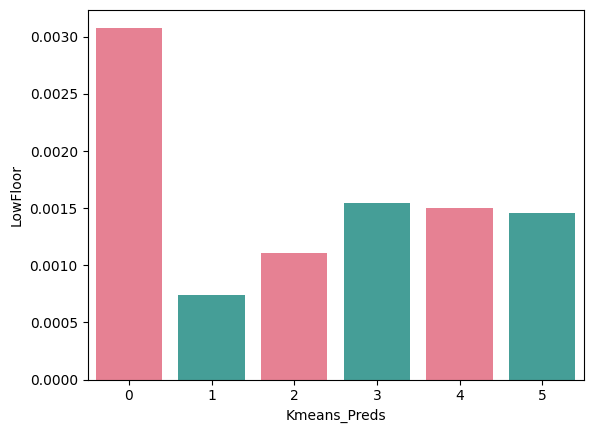

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


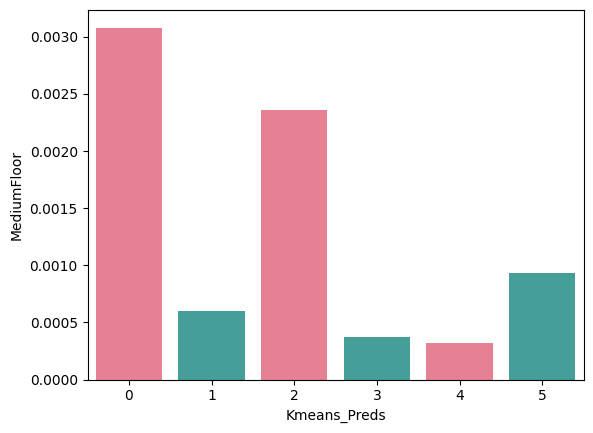

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


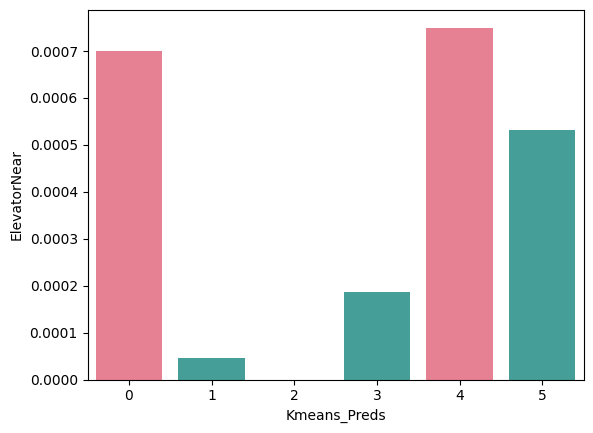

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


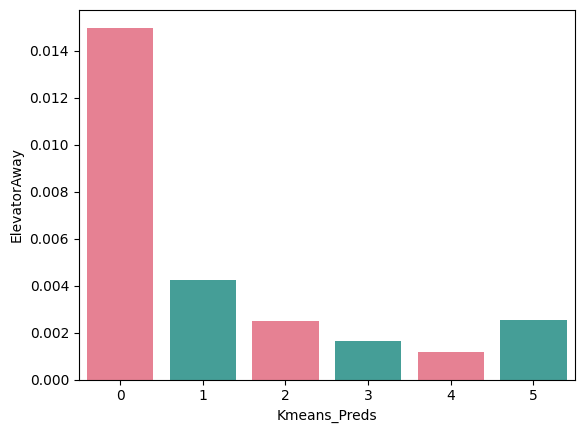

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


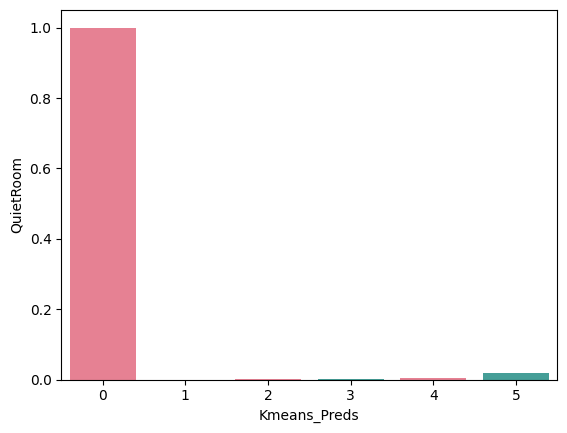

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/2143652131.py:19: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)


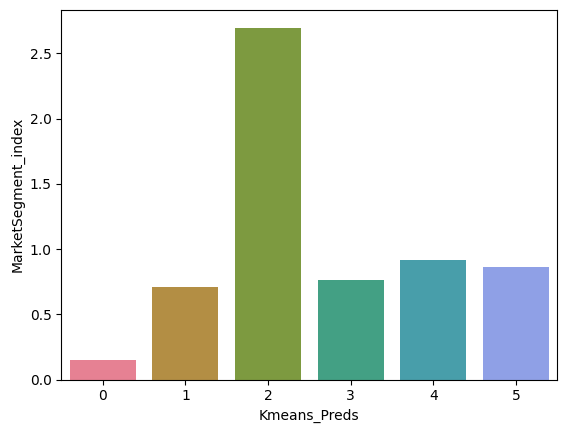

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz_km = km_preds.select('Age','LodgingRevenue','OtherRevenue','BookingsNoShowed',
                      'BookingsCanceled','BookingsCheckedIn','PersonsNights',
                      'HighFloor','LowFloor','MediumFloor','ElevatorNear','ElevatorAway',
                      'QuietRoom','Nationality_index','MarketSegment_index',
                      'Kmeans_Preds')
df_viz_km = df_viz_km.toPandas()
avg_df = df_viz_km.groupby(['Kmeans_Preds'], as_index=False).mean()

list1 = ['Age','LodgingRevenue','OtherRevenue','BookingsNoShowed',
                      'BookingsCanceled','BookingsCheckedIn','PersonsNights',
                      'HighFloor','LowFloor','MediumFloor','ElevatorNear','ElevatorAway',
                      'QuietRoom','MarketSegment_index']

for i in list1:
    colors = sns.color_palette('husl', len(df_viz_km[str(i)].unique()))
    sns.barplot(x='Kmeans_Preds',y=str(i),data=avg_df, palette=colors)

    plt.show()

### Gaussian Mixture Model (GMM)

In [20]:
from pyspark.ml.clustering import GaussianMixture

seed = 42

gmm = GaussianMixture(featuresCol='standardized').setK(6).setSeed(seed)
gmm_model = gmm.fit(data_scale_output)
gmm_model.setPredictionCol("GMM_Preds")
gmm_preds = gmm_model.transform(data_scale_output)

print("Gaussians shown as a DataFrame: ")
gmm_model.gaussiansDF.show()
gmm_preds.show()

24/04/24 10:24:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Gaussians shown as a DataFrame: 
+--------------------+--------------------+
|                mean|                 cov|
+--------------------+--------------------+
|[1.5289551443556,...|1.228044343074618...|
|[2.48343992595767...|0.445505684661541...|
|[1.81458150125314...|0.943007111895517...|
|[1.47480048731402...|0.918482645351262...|
|[1.5289551443556,...|1.228044343074618...|
|[1.5289551443556,...|1.228044343074618...|
+--------------------+--------------------+

+---+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+-----------------+-------------------------+-------------------+--------------------+--------------------+--------------------+---------+
| ID|Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|Book

Analysis of Cluster

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: The palette list has more values (105) than needed (4), which may not be intended.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


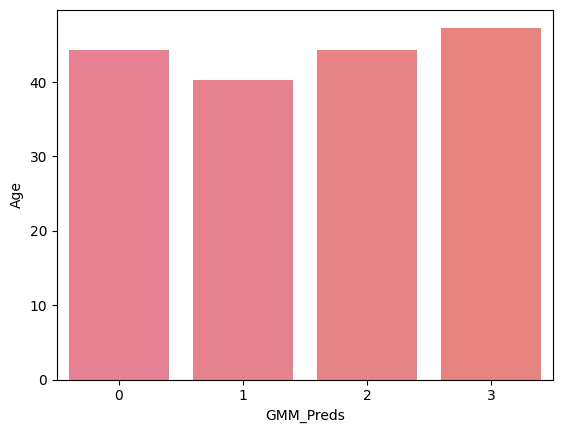

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: The palette list has more values (10257) than needed (4), which may not be intended.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


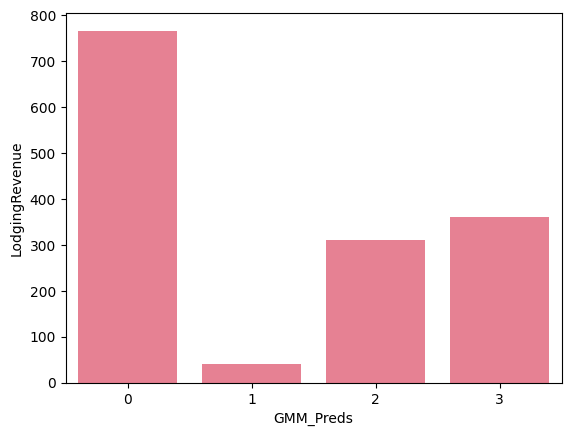

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: The palette list has more values (4490) than needed (4), which may not be intended.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


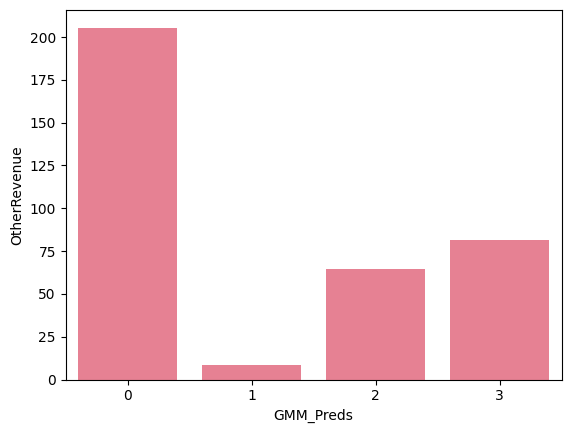

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


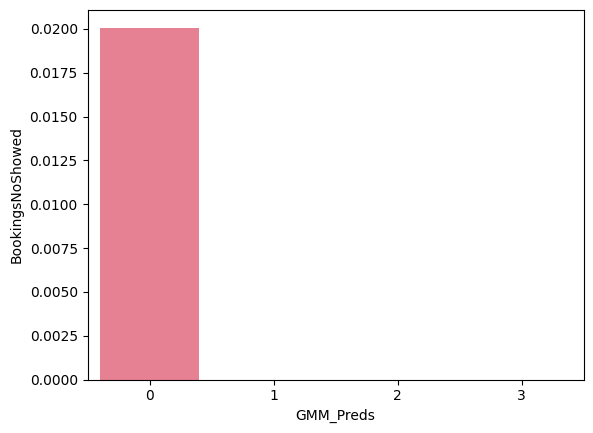

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


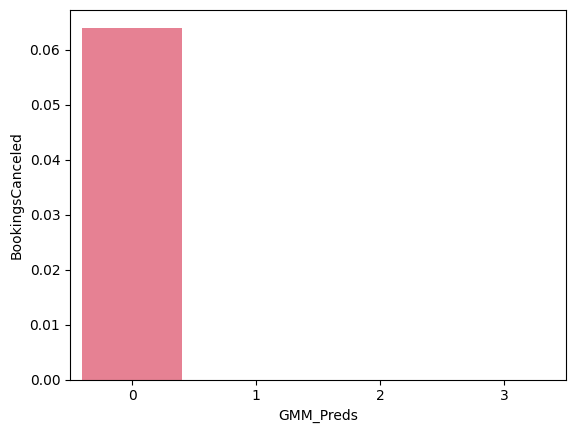

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: The palette list has more values (29) than needed (4), which may not be intended.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


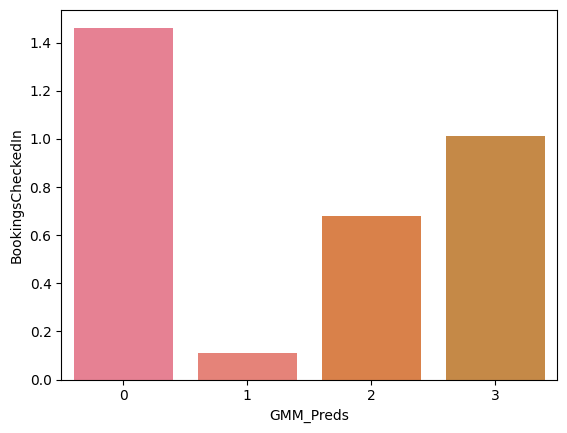

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: The palette list has more values (56) than needed (4), which may not be intended.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


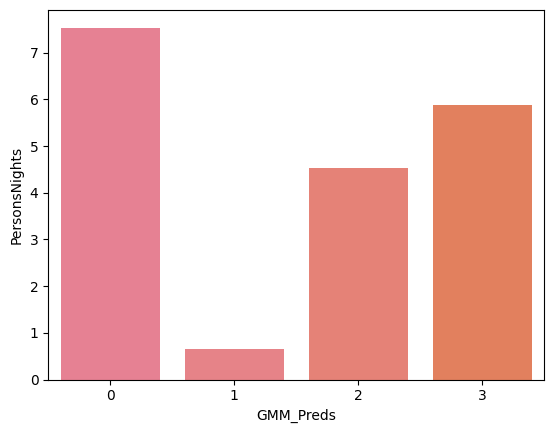

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


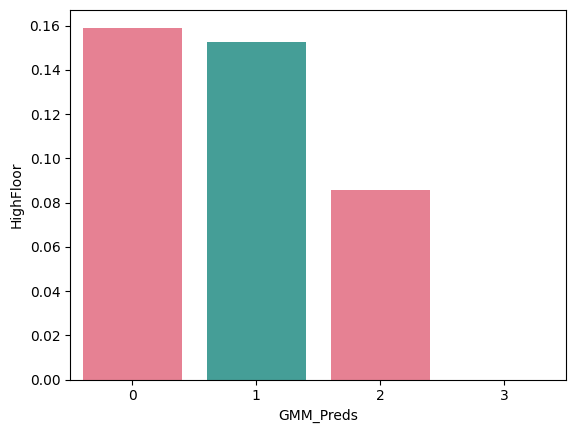

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


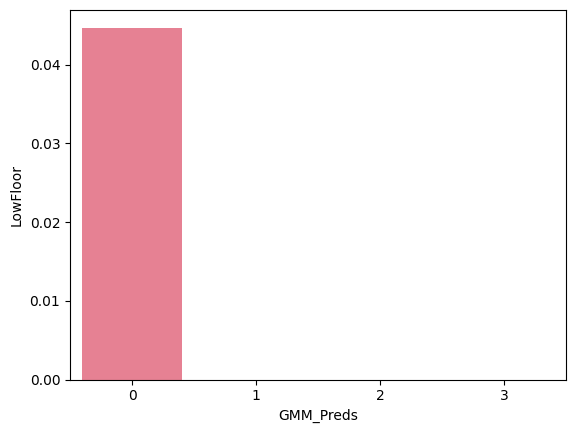

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


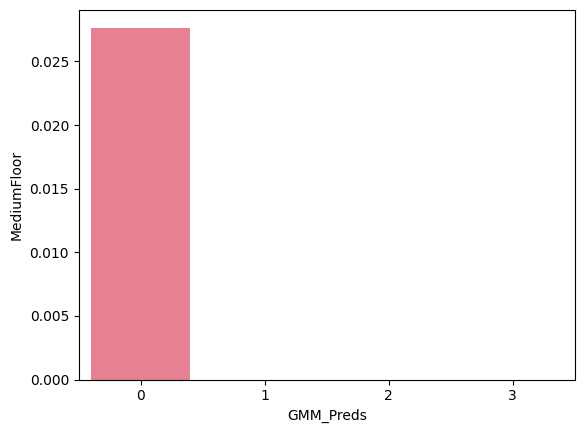

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


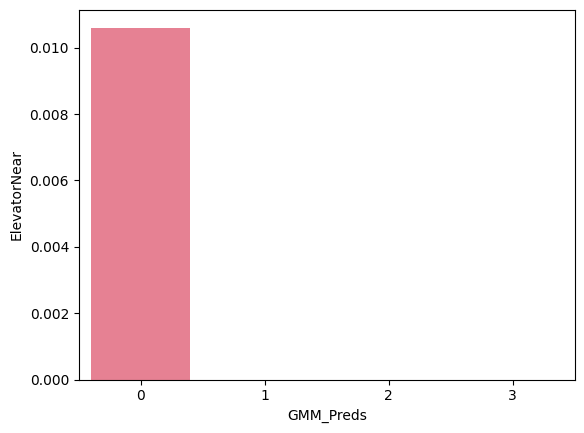

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


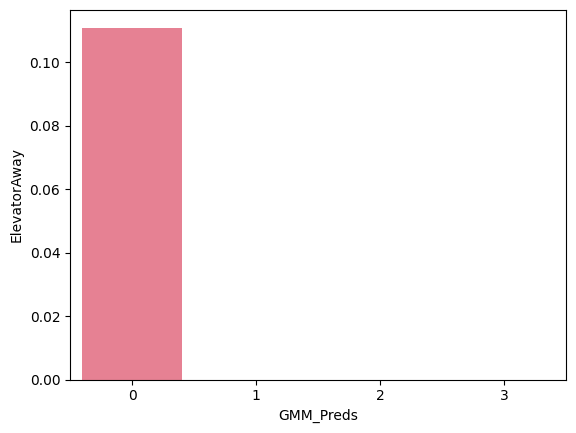

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


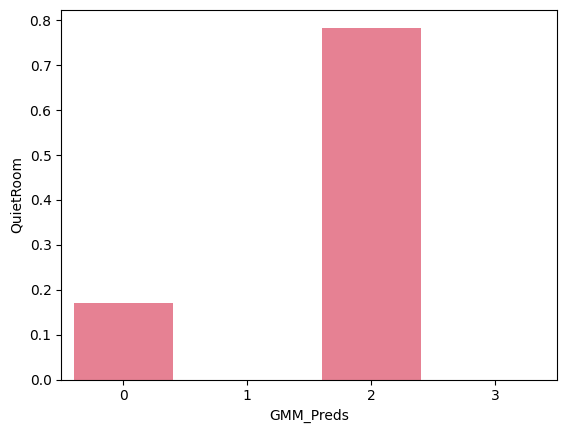

/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)
/var/folders/93/cmr4jmx15j11rrph25hd54p40000gn/T/ipykernel_34701/338135439.py:11: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)


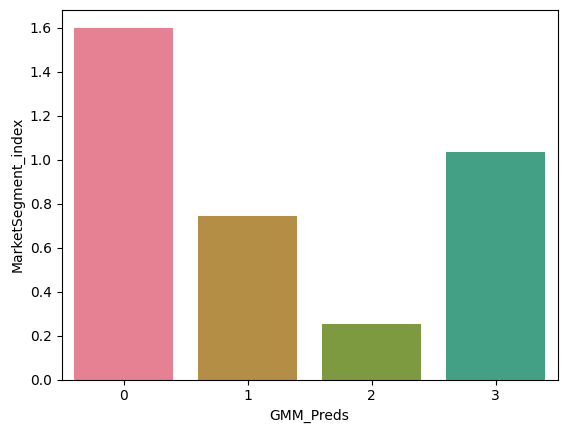

In [21]:
df_viz_gmm = gmm_preds.select('Age','LodgingRevenue','OtherRevenue','BookingsNoShowed',
											'BookingsCanceled','BookingsCheckedIn','PersonsNights',
											'HighFloor','LowFloor','MediumFloor','ElevatorNear','ElevatorAway',
											'QuietRoom','Nationality_index','MarketSegment_index',
											'GMM_Preds')
df_viz_gmm = df_viz_gmm.toPandas()
avg_df = df_viz_gmm.groupby(['GMM_Preds'], as_index=False).mean()

for i in list1:
		colors = sns.color_palette('husl', len(df_viz_gmm[str(i)].unique()))
		sns.barplot(x='GMM_Preds',y=str(i),data=avg_df, palette=colors)

		plt.show()

# Comparison of how many are similarly predicted

In [22]:
preds_col = km_preds.select('Kmeans_Preds').toPandas()
preds_col['GMM_Preds'] = gmm_preds.select('GMM_Preds').toPandas()
preds_col

,Kmeans_Preds,GMM_Preds
0,2,0
1,1,3
2,3,2
3,1,3
4,3,2
...,...,...
83585,3,1
83586,4,3
83587,3,1
83588,5,3


In [49]:
preds_col[preds_col['Kmeans_Preds'] == 0]['GMM_Preds'].value_counts()

GMM_Preds
2    6757
0     385
Name: count, dtype: int64

In [39]:
clusters_count = pd.DataFrame(columns=range(6))

for i in range(6):
		clusters_count.loc[i] = preds_col[preds_col['Kmeans_Preds'] == i]['GMM_Preds'].value_counts().reindex(range(6), fill_value=0)


clusters_count


,0,1,2,3,4,5
0,385,0,6757,0,0,0
1,307,807,222,20385,0,0
2,557,281,236,6132,0,0
3,457,16333,1085,3442,0,0
4,778,551,293,17046,0,0
5,156,317,252,6811,0,0


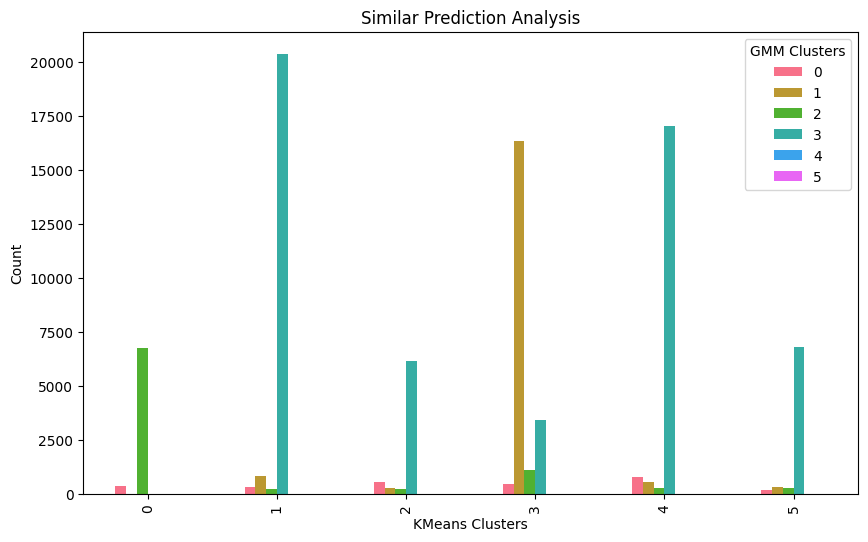

In [51]:
# plot grouped bar chart combining each i
clusters_count.plot(kind='bar', figsize=(10, 6), color=sns.color_palette('husl', 6))
plt.title('Similar Prediction Analysis')
plt.legend(title='GMM Clusters')
plt.xlabel('KMeans Clusters')
plt.ylabel('Count')
plt.show()